# Classification and cleaning of ITS data in LP4

1. remove short sequences (qiime-feature-table filter-seqs)
2. classification
3. remove non-fungal reads 
4. run decontam
5. remove pos/neg controls and potentially macrofungi (check out taxonomy first)
6. check again composition before performing alpha rarefaction

-->> decided to proceed with dada1 for ITS

In [1]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni


In [2]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the working directory
wd = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS


In [3]:
import qiime2 as q2

from qiime2 import (Artifact,
                    Metadata as qmd)

from qiime2.plugins import (cutadapt,
                            demux,
                            feature_table as qft,
                            taxa as q2t,)

from qiime2 import Metadata
from qiime2 import Visualization

from qiime2.plugins.feature_table.methods import (merge_seqs, merge, filter_seqs, filter_samples, filter_features) 
import qiime2.plugins.feature_classifier.actions as feature_classifier_actions
import qiime2.plugins.metadata.actions as metadata_actions
import qiime2.plugins.taxa.actions as taxa_actions
import qiime2.plugins.phylogeny.actions as phylogeny_actions
from qiime2.plugins.fragment_insertion.methods import sepp


%matplotlib inline

# 1. remove very short reads

-->> shortest reads are 20 bps, remove everything shorter than 50 bp.

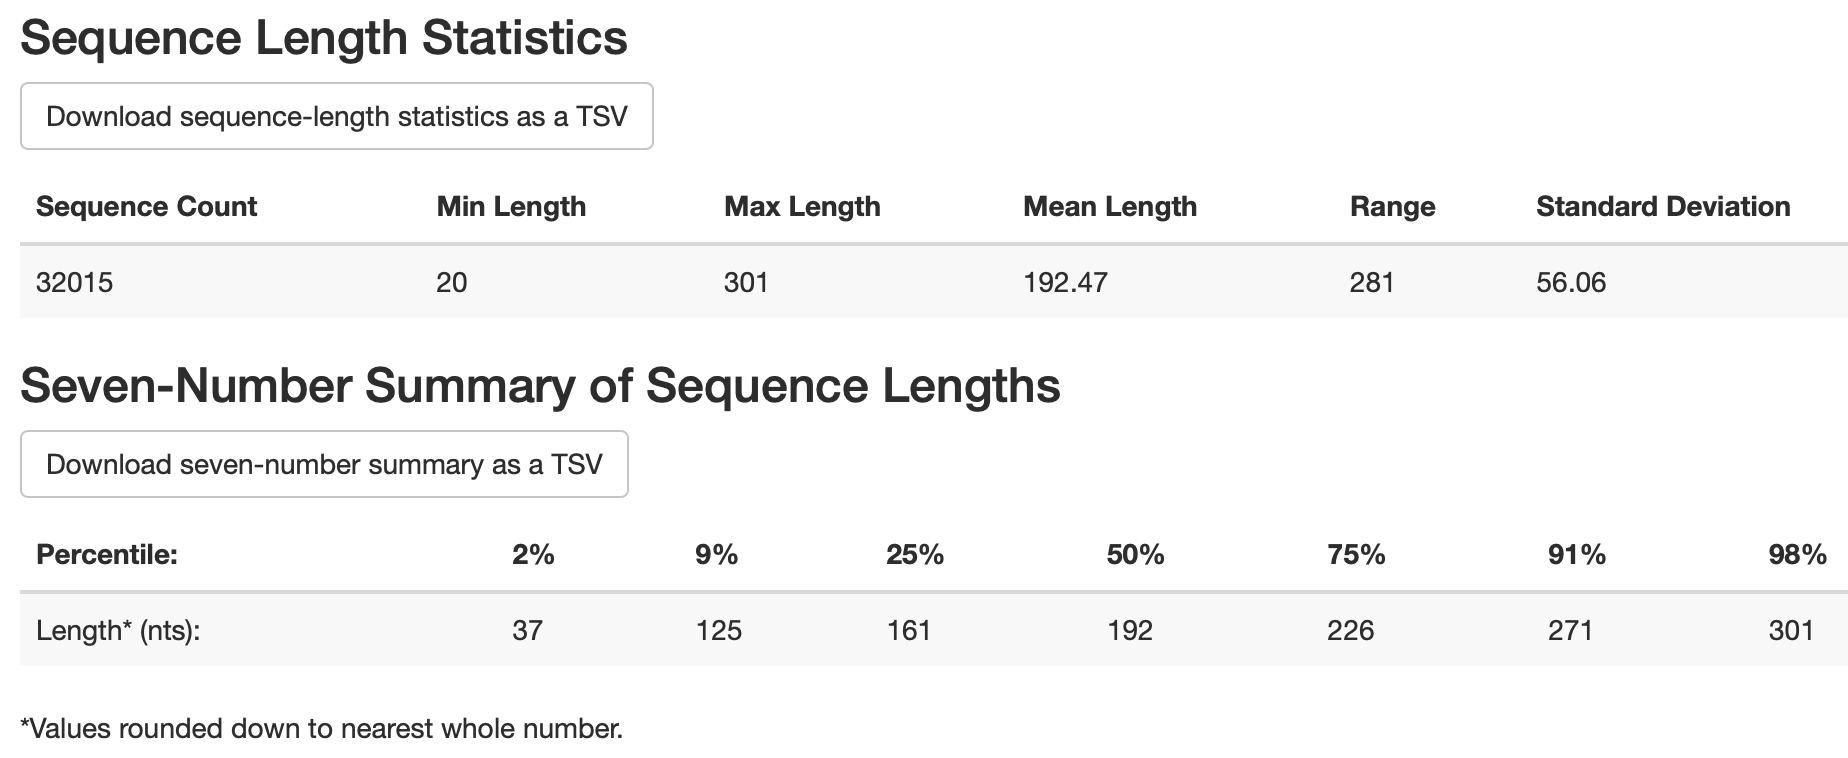

In [ ]:
qiime rescript filter-seqs-length \
  --i-sequences dada2/dada1-rep-seqs.qza \
  --p-global-min 50 \
  --o-filtered-seqs dada2/filtered-dada1-rep-seqs.qza \
  --o-discarded-seqs dada2/filtered-dada1-rep-seqs-discard.qza



In [ ]:
qiime feature-table filter-features \
  --i-table dada2/dada1-table.qza \
  --m-metadata-file dada2/filtered-dada1-rep-seqs.qza \
  --o-filtered-table dada2/filtered-dada1-table.qza


I realized that the sample IDS are like this: 366293_373-LP4-16S-0373_S845, which means to more efficiently proceed with merging and so on I first need to truncate all IDs to the first 23 characters and then continue again with classification. This will be easier to do now before prceeding with processing, since otherwise in each step it would need to be done before merging with metadata...

first: export the artifacts:

In [ ]:
qiime tools export --input-path filtered-dada1-rep-seqs.qza --output-path exported_rep_seqs
qiime tools export --input-path dada1-stats.qza --output-path exported_stats
qiime tools export --input-path filtered-dada1-table.qza --output-path exported_table

now, convert the feature table and change ids

In [ ]:
biom convert -i exported_table/feature-table.biom -o feature-table.tsv --to-tsv


In [ ]:
biom convert -i modified-feature-table.tsv -o feature-table.biom --to-hdf5

then do the same for the stats file: do it directly by opening the tsv and doing in excel

rep-seqs: do not have to be modified since there is only the feature id in the file but not the sample id, just continue with the previous re-seq file!!

Then re-import all the files to qiime2:

In [ ]:
#feature table:
qiime tools import --input-path feature-table.biom --type 'FeatureTable[Frequency]' --output-path modified-dada1-table.qza
#stats:
qiime tools import --input-path exported_stats/stats.tsv --type 'SampleData[DADA2Stats]' --output-path modified-dada1-stats.qza



In [ ]:
qiime metadata tabulate \
--m-input-file modified-dada1-stats.qza \
--o-visualization modified-dada1-stats.qzv
qiime feature-table summarize \
--i-table modified-dada1-table.qza \
--o-visualization modified-dada1-table.qzv

then continue with the modified files for all subsequent analyses!!!

# 2. classify the sequences

In [4]:
## Load dada table and rep seqs  

# this is the `FeatureData[Sequence]` 
rep_seqs = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/dada2/filtered-dada1-rep-seqs.qza')

# `FeatureTable[Frequency]` filtered after the aligned hits
table = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/dada2/modified-dada1-table.qza')

In [5]:
fn = '/home/meyeanni/public/Data/Databases/QIIME2/UNITE/unite_ver10_99_all_04.04.2024-Q2-2024.5.qza'
classifier = Artifact.load(fn)

In [6]:
# load metadata 
metadata = '/home/meyeanni/cloud/meyeanni/LP4/LP4_metadata.tsv'
md = Metadata.load(metadata)

In [7]:
taxonomy, = feature_classifier_actions.classify_sklearn(
    classifier=classifier,
    reads=rep_seqs,
    confidence=0,
    reads_per_batch=1000,
    read_orientation='same',
    n_jobs=1  # Make sure this is a valid number of threads for your environment
)

taxonomy_as_md_md = taxonomy.view(Metadata)
taxonomy_viz, = metadata_actions.tabulate(
    input=taxonomy_as_md_md,
)

taxonomy.save('sklearn/taxonomy_dada1.qza')
taxonomy_viz.save('sklearn/taxonomy_dada1.qzv')

'sklearn/taxonomy_dada1.qzv'

look at the classifications

In [7]:
import qiime2
import pandas as pd

# Load the taxonomy .qza file
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')
feature_table = qiime2.Artifact.load('dada2/modified-dada1-table.qza')


# Extract the data as a pandas DataFrame
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
feature_table = feature_table.view(pd.DataFrame)

# Transpose the DataFrame
feature_table_t = feature_table.T
# Reset the index to make 'Feature ID' a column again
feature_table_t.reset_index(inplace=True)
feature_table_t.rename(columns={'index': 'Feature ID'}, inplace=True)
feature_table_t

taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

,Feature ID,Taxon,Confidence
0,d8988d0c19e93a0f32b0aa471b74e452,k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__L...,0.018784745892320973
1,1bd2147eda3fbd7418a1c94885229e37,k__Fungi;p__Entomophthoromycota;c__Entomophtho...,0.043961762128229255
2,4d4e61fed7e2249fb5b64514c00d86d9,k__Stramenopila;p__Ochrophyta;c__Bacillariophy...,0.26233536055811163
3,527ad00bae9e7c1c3848b6db6d319b77,k__Metazoa;p__Mollusca;c__Gastropoda;o__Basomm...,0.33560328659691085
4,9eba8141a523f5e62a5a6bca73ee62d9,k__Stramenopila;p__Ochrophyta;c__Bacillariophy...,0.10272346880331189
...,...,...,...
31185,fe92f07c5b046fc8262cdcee9fcf9810,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.9860689398778287
31186,527edc503c0b6e0ae0ff86eb22d21f96,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.7152450618325837
31187,8e6ac178a6e8d1bc4bc73a9e1a2520c5,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.9999863290528572
31188,1f88cf00f736f183fb85736a794f7fd9,k__Eukaryota_kgd_Incertae_sedis;p__Eukaryota_p...,0.9999998631322834


In [8]:
# Extract the 'Family' level from the taxonomy string
taxonomy_sklearn['Kingdom'] = taxonomy_sklearn['Taxon'].str.split(';').str[0]

# Merge the feature table and taxonomy on the 'Feature ID' column
merged_data = pd.merge(feature_table_t, taxonomy_sklearn[['Feature ID', 'Kingdom']], left_on='Feature ID', right_on='Feature ID')

# Select only numeric columns for summation (i.e., sample columns)
numeric_columns = merged_data.select_dtypes(include=['number']).columns

# Group by 'Family' and sum feature counts, then reset the index
feature_sums = merged_data.groupby('Kingdom')[numeric_columns].sum().sum(axis=1).reset_index()

# Rename the columns for clarity
feature_sums.columns = ['Kingdom', 'Total_Features']

# Calculate percentages
total_features = feature_sums['Total_Features'].sum()
feature_sums['Percentage'] = (feature_sums['Total_Features'] / total_features) * 100# Calculate percentages


# Display the aggregated data
print(feature_sums)

                            Kingdom  Total_Features  Percentage
0                      k__Alveolata          4905.0    0.010033
1                      k__Amoebozoa          2043.0    0.004179
2                       k__Apusozoa            14.0    0.000029
3   k__Eukaryota_kgd_Incertae_sedis         29489.0    0.060316
4                          k__Fungi      47312777.0   96.772510
5                   k__Heterolobosa           831.0    0.001700
6                  k__Ichthyosporia            99.0    0.000202
7                        k__Metazoa         31155.0    0.063724
8                       k__Protista         30061.0    0.061486
9                       k__Rhizaria           275.0    0.000562
10                  k__Stramenopila        539494.0    1.103469
11                 k__Viridiplantae        939577.0    1.921790


In [9]:
feature_sums.sum()

Kingdom           k__Alveolatak__Amoebozoak__Apusozoak__Eukaryot...
Total_Features                                           48890720.0
Percentage                                                    100.0
dtype: object

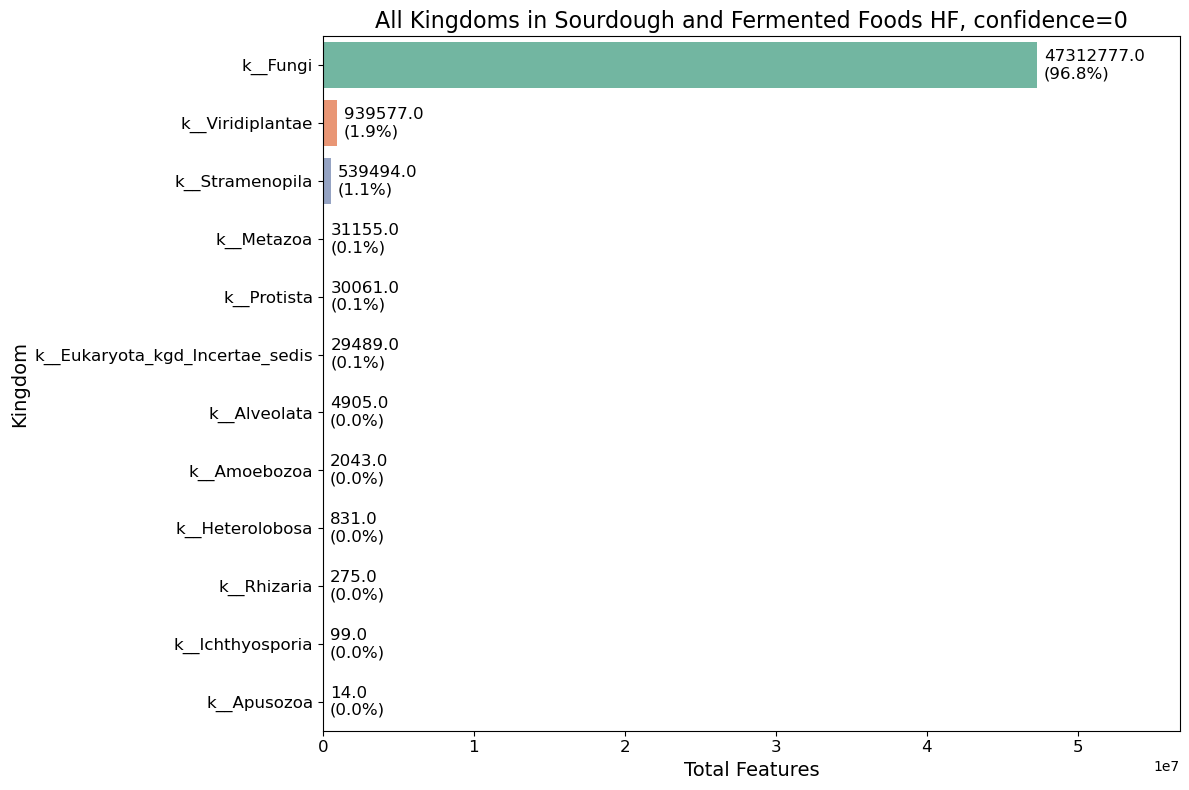

In [10]:
# Select only numeric columns for summation (i.e., sample columns)
numeric_columns = merged_data.select_dtypes(include=['number']).columns

# Group by 'Genus' and sum feature counts, then reset the index
feature_sums = merged_data.groupby('Kingdom')[numeric_columns].sum().sum(axis=1).reset_index()

# Rename the columns for clarity
feature_sums.columns = ['Kingdom', 'Total_Features']

# Sort the genera by total features and select the top 20
feature_sums = feature_sums.sort_values(by='Total_Features', ascending=False).head(20)

# Calculate percentages
total_features = feature_sums['Total_Features'].sum()
feature_sums['Percentage'] = (feature_sums['Total_Features'] / total_features) * 100

# Plot the data (horizontal bars)
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Total_Features', y='Kingdom', data=feature_sums, palette='Set2')

# Customize the plot
plt.title('All Kingdoms in Sourdough and Fermented Foods HF, confidence=0', fontsize=16)
plt.xlabel('Total Features', fontsize=14)
plt.ylabel('Kingdom', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add annotations for percentages
for p in bar_plot.patches:
    width = p.get_width()
    genus = feature_sums.loc[feature_sums['Total_Features'] == width, 'Kingdom'].values[0]
    percentage = feature_sums.loc[feature_sums['Kingdom'] == genus, 'Percentage'].values[0]
    bar_plot.annotate(f'{width}\n({percentage:.1f}%)',
                      (width, p.get_y() + p.get_height() / 2.),
                      ha='left', va='center', fontsize=12, color='black',
                      xytext=(5, 0), textcoords='offset points')

# Adjust x-axis limit for better readability
plt.xlim(0, feature_sums['Total_Features'].max() * 1.2)

# Show the plot
plt.tight_layout()
plt.show()

## 3. remove anything that is non-fungal!

In [ ]:
# Load the taxonomy .qza file
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')
feature_table = qiime2.Artifact.load('dada2/modified-dada1-table.qza')

In [11]:
! qiime taxa filter-table \
  --i-table dada2/modified-dada1-table.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude k__Viridiplantae,k__Stramenopila,k__Metazoa,k__Eukaryota_kgd_Incertae_sedis,k__Amoebozoa,k__Protista,k__Alveolata,k__Heterolobosa,k__Rhizaria,k__Ichthyosporia,k__Apusozoa \
  --o-filtered-table sklearn/fungi-table-all.qza

Saved FeatureTable[Frequency] to: sklearn/fungi-table-all.qza


check that it is actually removed

In [12]:
import qiime2
import pandas as pd

# Load the taxonomy .qza file
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')
feature_table = qiime2.Artifact.load('sklearn/fungi-table-all.qza')


# Extract the data as a pandas DataFrame
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
feature_table = feature_table.view(pd.DataFrame)

# Transpose the DataFrame
feature_table_t = feature_table.T
# Reset the index to make 'Feature ID' a column again
feature_table_t.reset_index(inplace=True)
feature_table_t.rename(columns={'index': 'Feature ID'}, inplace=True)
feature_table_t

taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

# Extract the 'Family' level from the taxonomy string
taxonomy_sklearn['Kingdom'] = taxonomy_sklearn['Taxon'].str.split(';').str[0]

# Merge the feature table and taxonomy on the 'Feature ID' column
merged_data = pd.merge(feature_table_t, taxonomy_sklearn[['Feature ID', 'Kingdom']], left_on='Feature ID', right_on='Feature ID')

# Select only numeric columns for summation (i.e., sample columns)
numeric_columns = merged_data.select_dtypes(include=['number']).columns

# Group by 'Family' and sum feature counts, then reset the index
feature_sums = merged_data.groupby('Kingdom')[numeric_columns].sum().sum(axis=1).reset_index()

# Rename the columns for clarity
feature_sums.columns = ['Kingdom', 'Total_Features']

# Calculate percentages
total_features = feature_sums['Total_Features'].sum()
feature_sums['Percentage'] = (feature_sums['Total_Features'] / total_features) * 100# Calculate percentages


# Display the aggregated data
print(feature_sums)

    Kingdom  Total_Features  Percentage
0  k__Fungi      47312777.0       100.0


also filter the sequences:

In [13]:
! qiime feature-table filter-seqs \
  --i-data dada2/filtered-dada1-rep-seqs.qza \
  --i-table sklearn/fungi-table-all.qza \
  --o-filtered-data sklearn/fungi-rep-seqs-all.qza

Saved FeatureData[Sequence] to: sklearn/fungi-rep-seqs-all.qza


## 4. run decontam

in plugin quality-control: https://docs.qiime2.org/2024.5/plugins/available/quality-control/decontam-identify-batches/


to be able to run the decontam command, all entries from the metadata which have no entry in the table-fungal-only.qzv have to be removed from the metadata, otherwise errors will occur..

In [ ]:
qiime tools export \
  --input-path sklearn/table-fungal-only.qza \
  --output-path sklearn/exported_table

In [ ]:
biom convert \
  -i sklearn/exported_table/feature-table.biom \
  -o sklearn/exported_table/feature-table.tsv \
  --to-tsv


make a new tsv file with ids to keep (copy column headers of previous feature table since it did not work to directly import...)

In [16]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the working directory
wd = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS


In [22]:
import pandas as pd

# Load the file with IDs to keep
ids_to_keep_df = pd.read_csv('ITS_ids.tsv', sep='\t')

# Load the metadata file
metadata_df = pd.read_csv('LP4_metadata_ITS.tsv', sep='\t')

# Convert both ID columns to sets for efficient filtering
ids_to_keep = set(ids_to_keep_df['ids'])
metadata_ids = metadata_df[metadata_df.columns[0]]  # Assuming the first column contains the sample IDs

# Filter the metadata to only keep rows with IDs present in the 'ids_to_keep'
filtered_metadata_df = metadata_df[metadata_ids.isin(ids_to_keep)]

# Save the filtered metadata to a new file
filtered_metadata_df.to_csv('filtered_LP4_metadata_ITS.tsv', sep='\t', index=False)

print(f"Filtered metadata saved to 'filtered_LP4_metadata_ITS.tsv'.")


Filtered metadata saved to 'filtered_LP4_metadata_ITS.tsv'.


--> then remove all entries that are not related EVO/highschool/shipping, plus make sure that controls are properly labelled (including empty wells that can be treated as controls too, try both once inlcuding them for decontam and once excluding them)

filter feature table

In [17]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS'

In [18]:
! qiime feature-table filter-samples \
  --i-table sklearn/fungi-table-all.qza \
  --m-metadata-file decontam/filtered_LP4_metadata_ITS_my_exp.tsv \
  --o-filtered-table decontam/table-fungal-all-only_my_exp.qza


Saved FeatureTable[Frequency] to: decontam/table-fungal-all-only_my_exp.qza


filter rep-seqs

In [20]:
!qiime feature-table filter-seqs \
  --i-data sklearn/fungi-rep-seqs-all.qza \
  --i-table decontam/table-fungal-all-only_my_exp.qza \
  --o-filtered-data decontam/fungal-rep-seqs_my_exp.qza



Saved FeatureData[Sequence] to: decontam/fungal-rep-seqs_my_exp.qza


qiime quality-control decontam-identify

tune parameters: combined  to maybe be able to exclude those sequences from the samples with more than 1000 features... 

In [ ]:
# qiime feature-table summarize \
#   --i-table decontam/table-fungal-all-only_my_exp.qza \
#   --o-visualization decontam/filtered_taxa_table_ITS_my_exp.qzv

In [22]:
! qiime tools export \
  --input-path decontam/table-fungal-all-only_my_exp.qza \
  --output-path decontam/filtered_taxa_table_exported


Exported decontam/table-fungal-all-only_my_exp.qza as BIOMV210DirFmt to directory decontam/filtered_taxa_table_exported


In [23]:
!biom convert \
  -i decontam/filtered_taxa_table_exported/feature-table.biom \
  -o decontam/filtered_taxa_table.csv \
  --to-tsv

In [25]:

import pandas as pd
from biom import load_table

# Load the biom file
biom_table = load_table('decontam/filtered_taxa_table_exported/feature-table.biom')

# Convert to DataFrame
df = biom_table.to_dataframe()
df = df.fillna(0)  # Replace NaNs with 0

# Sum read counts per sample
feature_frequency = df.sum(axis=0).reset_index()
feature_frequency.columns = ['SampleID', 'TotalObservedFeatures']

# Save to CSV if needed
feature_frequency.to_csv('decontam/feature_frequency.csv', index=False)

In [26]:
# Count unique features (i.e., count columns with non-zero values)
unique_features_count = (df > 0).astype(int).sum(axis=0).reset_index()
unique_features_count.columns = ['SampleID', 'UniqueFeaturesCount']
# Save to CSV if needed
unique_features_count.to_csv('decontam/batch_effects/unique_features_count.csv', index=False)

In [27]:
metadata = pd.read_csv('decontam/filtered_LP4_metadata_ITS_my_exp.tsv', sep='\t')  # Adjust sep if necessary
merged_df1 = pd.merge(metadata, unique_features_count, on='SampleID', how='left')
merged_df = pd.merge(merged_df1, feature_frequency, on='SampleID', how='left')

print(merged_df)
merged_df.to_csv('decontam/unique_features_frequency.csv', index=False)


                    SampleID label_barcode1 label_barcode2      created_date  \
0    366291_001-LP4-ITS-0001   ATATTTAGGTAT   CTACCGATTGCG  16.10.2024 14:59   
1    366291_002-LP4-ITS-0002   AGTACTGCAGGC   ATTTGCTTTGCC  16.10.2024 14:59   
2    366291_003-LP4-ITS-0003   CGGGTGAACCAT   GTGACCCTGTCA  16.10.2024 14:59   
3    366291_004-LP4-ITS-0004   CCTGGTCCACGG   GAGAATGGAAAG  16.10.2024 14:59   
4    366291_005-LP4-ITS-0005   GATAATAGGGAC   CAGTAGCGATAT  16.10.2024 14:59   
..                       ...            ...            ...               ...   
761  366292_264-LP4-ITS-0764   CGCCTCCTATGG   TAGGAGAGACAG  16.10.2024 14:59   
762  366292_265-LP4-ITS-0765   ACCCGAGGCCTC   GGTGTGAGAAAG  16.10.2024 14:59   
763  366292_266-LP4-ITS-0766   GTTTACCAAGTC   GTTCCATCGGCC  16.10.2024 14:59   
764  366292_267-LP4-ITS-0767   TCTTGATCTTGA   TACTTAAACATC  16.10.2024 14:59   
765  366292_268-LP4-ITS-0768   TATTGAATATTG   AGGGAGCTTCGG  16.10.2024 14:59   

    amplicon     unique_id  sample_id p

### run decontam with combined method

In [28]:
!qiime quality-control decontam-identify \
--i-table decontam/table-fungal-all-only_my_exp.qza \
--m-metadata-file decontam/ITS_unique_features_frequency.tsv \
--p-method combined \
--p-freq-concentration-column UniqueFeaturesCount \
--p-prev-control-column decontam_1 \
--p-prev-control-indicator control_n \
--o-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza

Saved FeatureData[DecontamScore] to: decontam/batch_effects/decontam_scores_decontam_1_comb.qza


In [29]:
!qiime quality-control decontam-score-viz \
--i-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza \
--i-table decontam/table-fungal-all-only_my_exp.qza \
--i-rep-seqs decontam/fungal-rep-seqs_my_exp.qza \
--p-threshold 0.02 \
--p-weighted \
--p-bin-size 0.01 \
--o-visualization decontam/batch_effects/decontam_comb_0.02.qzv

Saved Visualization to: decontam/batch_effects/decontam_comb_0.02.qzv


In [ ]:


# qiime quality-control decontam-remove \
# --i-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza \
# --i-table decontam/table-fungal-only_my_exp.qza \
# --i-rep-seqs decontam/fungal-rep-seqs_my_exp.qza \
# --p-threshold 0.04 \
# --o-filtered-table decontam/filtered_taxa_table_ITS_my_exp_decontam1_comb0.04.qza \
# --o-filtered-rep-seqs decontam/filtered_rep_seqs_ITS_my_exp_decontam1_comb0.04.qza

threshold 0.02, mainly 2 massive contaminants: Saccharomyces cerevisiae and another Saccharomyces cerevisiae strain.. seems like for now better do not use any decontam for that dataset

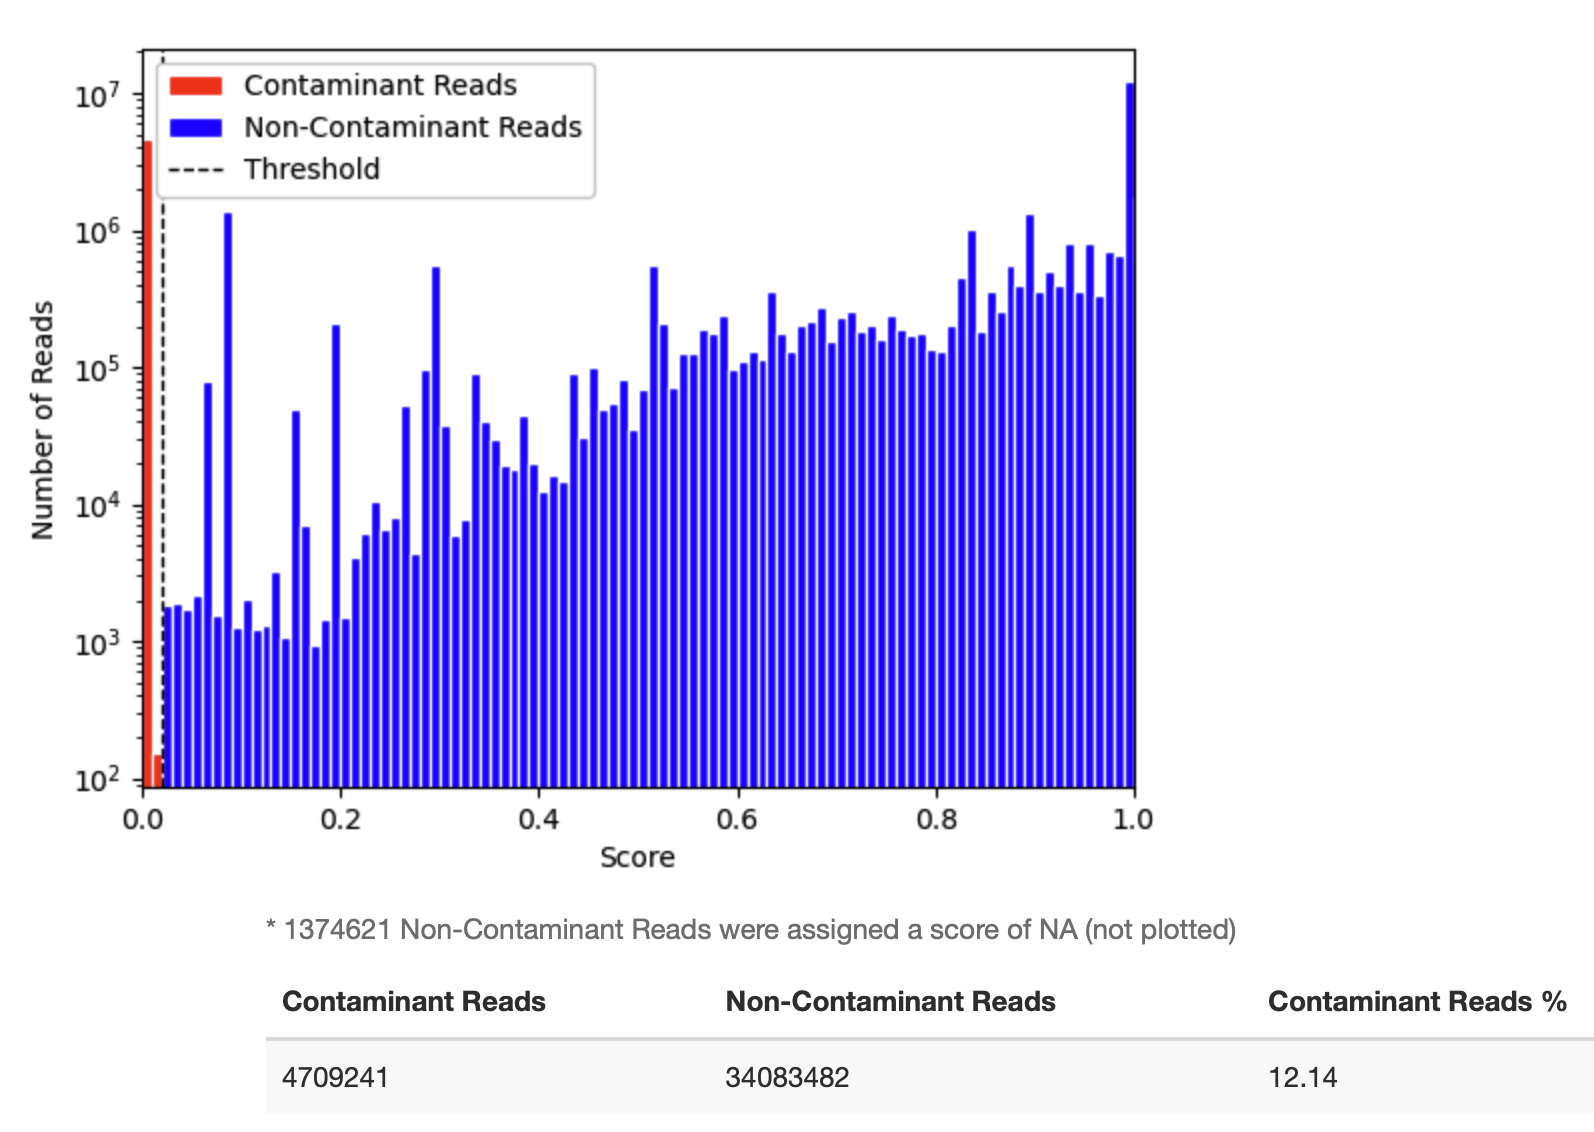

make some barplots to check positive controls (without decontam)

In [30]:
## Load dada table and rep seqs  

# this is the `FeatureData[Sequence]` 
rep_seqs_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/fungal-rep-seqs_my_exp.qza')

# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/table-fungal-all-only_my_exp.qza')

In [31]:
#taxonomy:
# `FeatureTable[Frequency]` filtered after the aligned hits
taxonomy_dada1 = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/sklearn/taxonomy_dada1.qza')

In [32]:
# load metadata 
metadata = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/ITS_unique_features_frequency.tsv'
md = Metadata.load(metadata)

In [33]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS'

In [34]:
taxa_bar_plots_viz, = taxa_actions.barplot(
    table=table_clean,
    taxonomy=taxonomy_dada1,
    metadata=md,
)
taxa_bar_plots_viz.save('decontam/taxa_barplot_fungal_only_my_exp.qzv')

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan n

'decontam/taxa_barplot_fungal_only_my_exp.qzv'

check positive controls: there should be 8 bacterial species present and 2 yeast: Saccharomyces cerevisiae and Cryptococcus neoformans
- Saccharomyces cerevisiae, yes
- Cryptococcus neoformans, yes

continue without decontam!!!

## 5. continue with cleaning the data: filter out positive and negative controls and remove low abundant ASVs

In [ ]:
# this is the `FeatureData[Sequence]` 
rep_seqs_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/fungal-rep-seqs_my_exp.qza')

# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/table-fungal-all-only_my_exp.qza')

In [36]:
! qiime feature-table filter-samples \
  --i-table decontam/table-fungal-all-only_my_exp.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl.tsv \
  --o-filtered-table decontam/table-fungal-all-only_my_exp-no-ctrls.qza

Saved FeatureTable[Frequency] to: decontam/table-fungal-all-only_my_exp-no-ctrls.qza


In [37]:
! qiime feature-table filter-features \
  --i-table decontam/table-fungal-all-only_my_exp-no-ctrls.qza \
  --p-min-frequency 10 \
  --p-min-samples 1 \
  --o-filtered-table decontam/table-fungal-all-only_my_exp-filt-1.qza

Saved FeatureTable[Frequency] to: decontam/table-fungal-all-only_my_exp-filt-1.qza


Top 10 Removed Taxa:
                             Feature ID  \
30299  4b9664403cffea8f0fddb1f6753b5255   
31025  3c1b48425376383b7fa3e40887bbf897   
4965   311ac77bb6f7aa8b6df229d55050f234   
5070   011efd1fb3af1a5e3d2c50e07f82c3a6   
5104   8ecd1b0e82e2bc423b32b5be172addcb   
4165   7b92773a2b88fb7f09d8899a65f0a235   
20243  406a19a5afd65dc91f37e01fa4359094   
19301  f8b455ec47913144f275c743c54b591f   
19276  b90f6427e2ab10128e150e94ed67a9c2   
19788  65963b6e2e58fa1f18f4c1a506aff032   

                                                   Taxon           Confidence  \
30299  k__Fungi;p__Ascomycota;c__Sordariomycetes;o__D...   0.5600345221691341   
31025  k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__L...  0.06905398023499071   
4965   k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   0.8545147606211886   
5070   k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   0.6084106075393884   
5104   k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...  0.10718769797120302   
4165   k__Fungi;p__

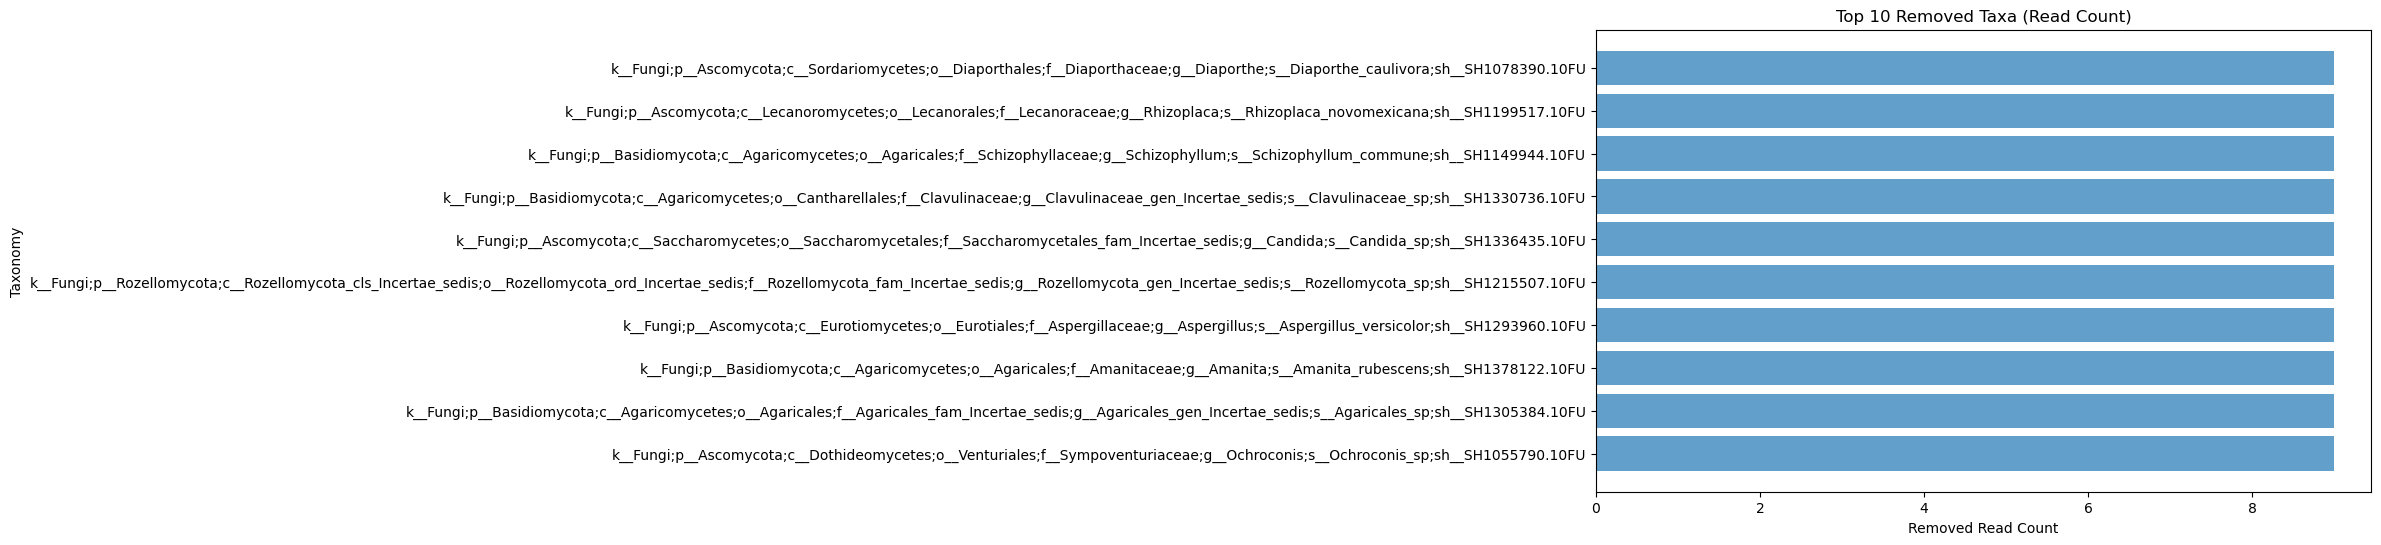

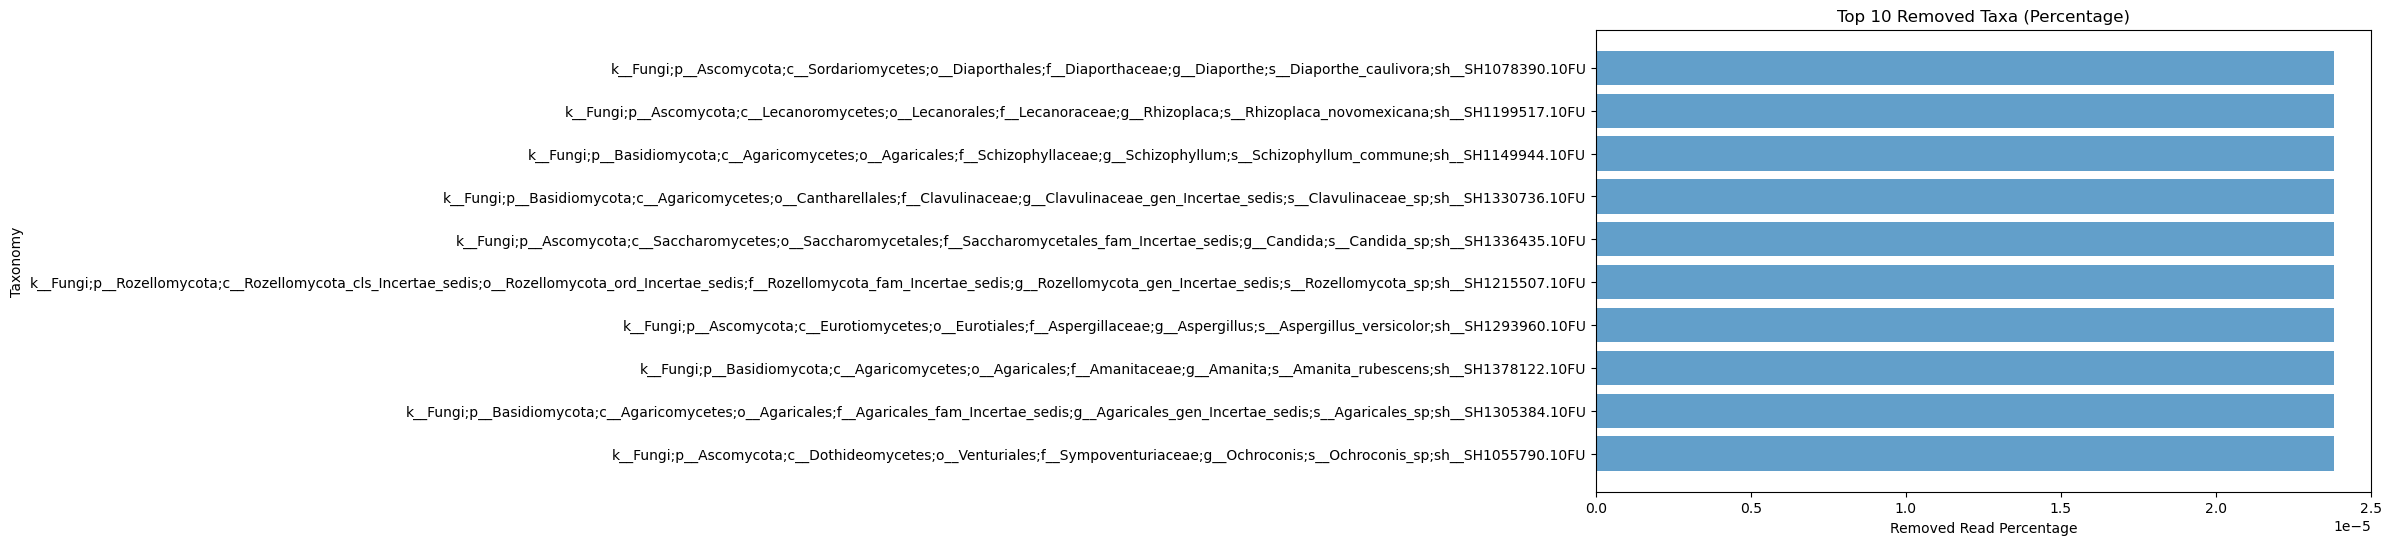

In [38]:
# Load the taxonomy .qza file
fungi_before = qiime2.Artifact.load('decontam/table-fungal-all-only_my_exp-no-ctrls.qza')
fungi_after = qiime2.Artifact.load('decontam/table-fungal-all-only_my_exp-filt-1.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')


# Extract the data as a pandas DataFrame
fungi_b = fungi_before.view(pd.DataFrame)
fungi_a = fungi_after.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)



taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

# Identify removed features
removed_features = set(fungi_b.columns) - set(fungi_a.columns)
removed_features_list = list(removed_features)
# Extract removed features and their taxonomy
removed_features_df = taxonomy_sklearn[taxonomy_sklearn['Feature ID'].isin(removed_features_list)]

# Calculate removed read counts for these features
removed_read_counts = fungi_b[removed_features_list].sum()

# Merge taxonomy with removed read counts
removed_features_summary = removed_features_df.merge(
    removed_read_counts.rename("Removed Read Count"),
    left_on="Feature ID",
    right_index=True
)

# Calculate percentages
total_reads = fungi_b.sum().sum()
removed_features_summary['Removed Read Percentage'] = (
    removed_features_summary['Removed Read Count'] / total_reads
) * 100

# Sort by read count
removed_features_summary_sorted = removed_features_summary.sort_values(by="Removed Read Count", ascending=False)

# Print the top 10 removed taxa
print("Top 10 Removed Taxa:")
print(removed_features_summary_sorted.head(10))

# Visualization: Counts and percentages of removed taxa
import matplotlib.pyplot as plt

top_removed = removed_features_summary_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_removed['Taxon'], top_removed['Removed Read Count'], alpha=0.7)
plt.xlabel('Removed Read Count')
plt.ylabel('Taxonomy')
plt.title('Top 10 Removed Taxa (Read Count)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_removed['Taxon'], top_removed['Removed Read Percentage'], alpha=0.7)
plt.xlabel('Removed Read Percentage')
plt.ylabel('Taxonomy')
plt.title('Top 10 Removed Taxa (Percentage)')
plt.gca().invert_yaxis()
plt.show()

In [39]:
# Calculate feature frequencies and sample counts
feature_total_reads = fungi_b.sum(axis=0)  # Total reads per feature
feature_sample_counts = (fungi_b > 0).sum(axis=0)  # Number of samples each feature appears in

# Identify features to be removed based on filtering criteria
filtered_out_features = feature_total_reads[(feature_total_reads < 20) | (feature_sample_counts < 1)]
print(f"Number of features filtered out if threshold would be 20 reads: {len(filtered_out_features)}")

# Verify overlap with the removed features
print(f"Overlap between filtered features and removed features with threshold 10 reads: {len(set(filtered_out_features.index) & set(removed_features_list))}")

Number of features filtered out if threshold would be 20 reads: 5133
Overlap between filtered features and removed features with threshold 10 reads: 3294


### time to filter out the shipping samples (and check regarding the control sample(s))

In [ ]:
! qiime feature-table filter-samples \
  --i-table decontam/table-fungal-all-only_my_exp.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl.tsv \
  --o-filtered-table decontam/table-fungal-all-only_my_exp-no-ctrls.qza

In [42]:
! qiime feature-table filter-samples \
  --i-table decontam/table-fungal-all-only_my_exp.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping.tsv \
  --o-filtered-table decontam/table-fungai-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/table-fungai-shipping.qza


In [43]:
# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/table-fungai-shipping.qza')
taxa_bar_plots_viz, = taxa_actions.barplot(
    table=table_clean,
    taxonomy=taxonomy_artifact_sklearn,
    metadata=md,
)
taxa_bar_plots_viz.save('decontam/taxa_barplot_filt_shipping_check.qzv')

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan n

'decontam/taxa_barplot_filt_shipping_check.qzv'

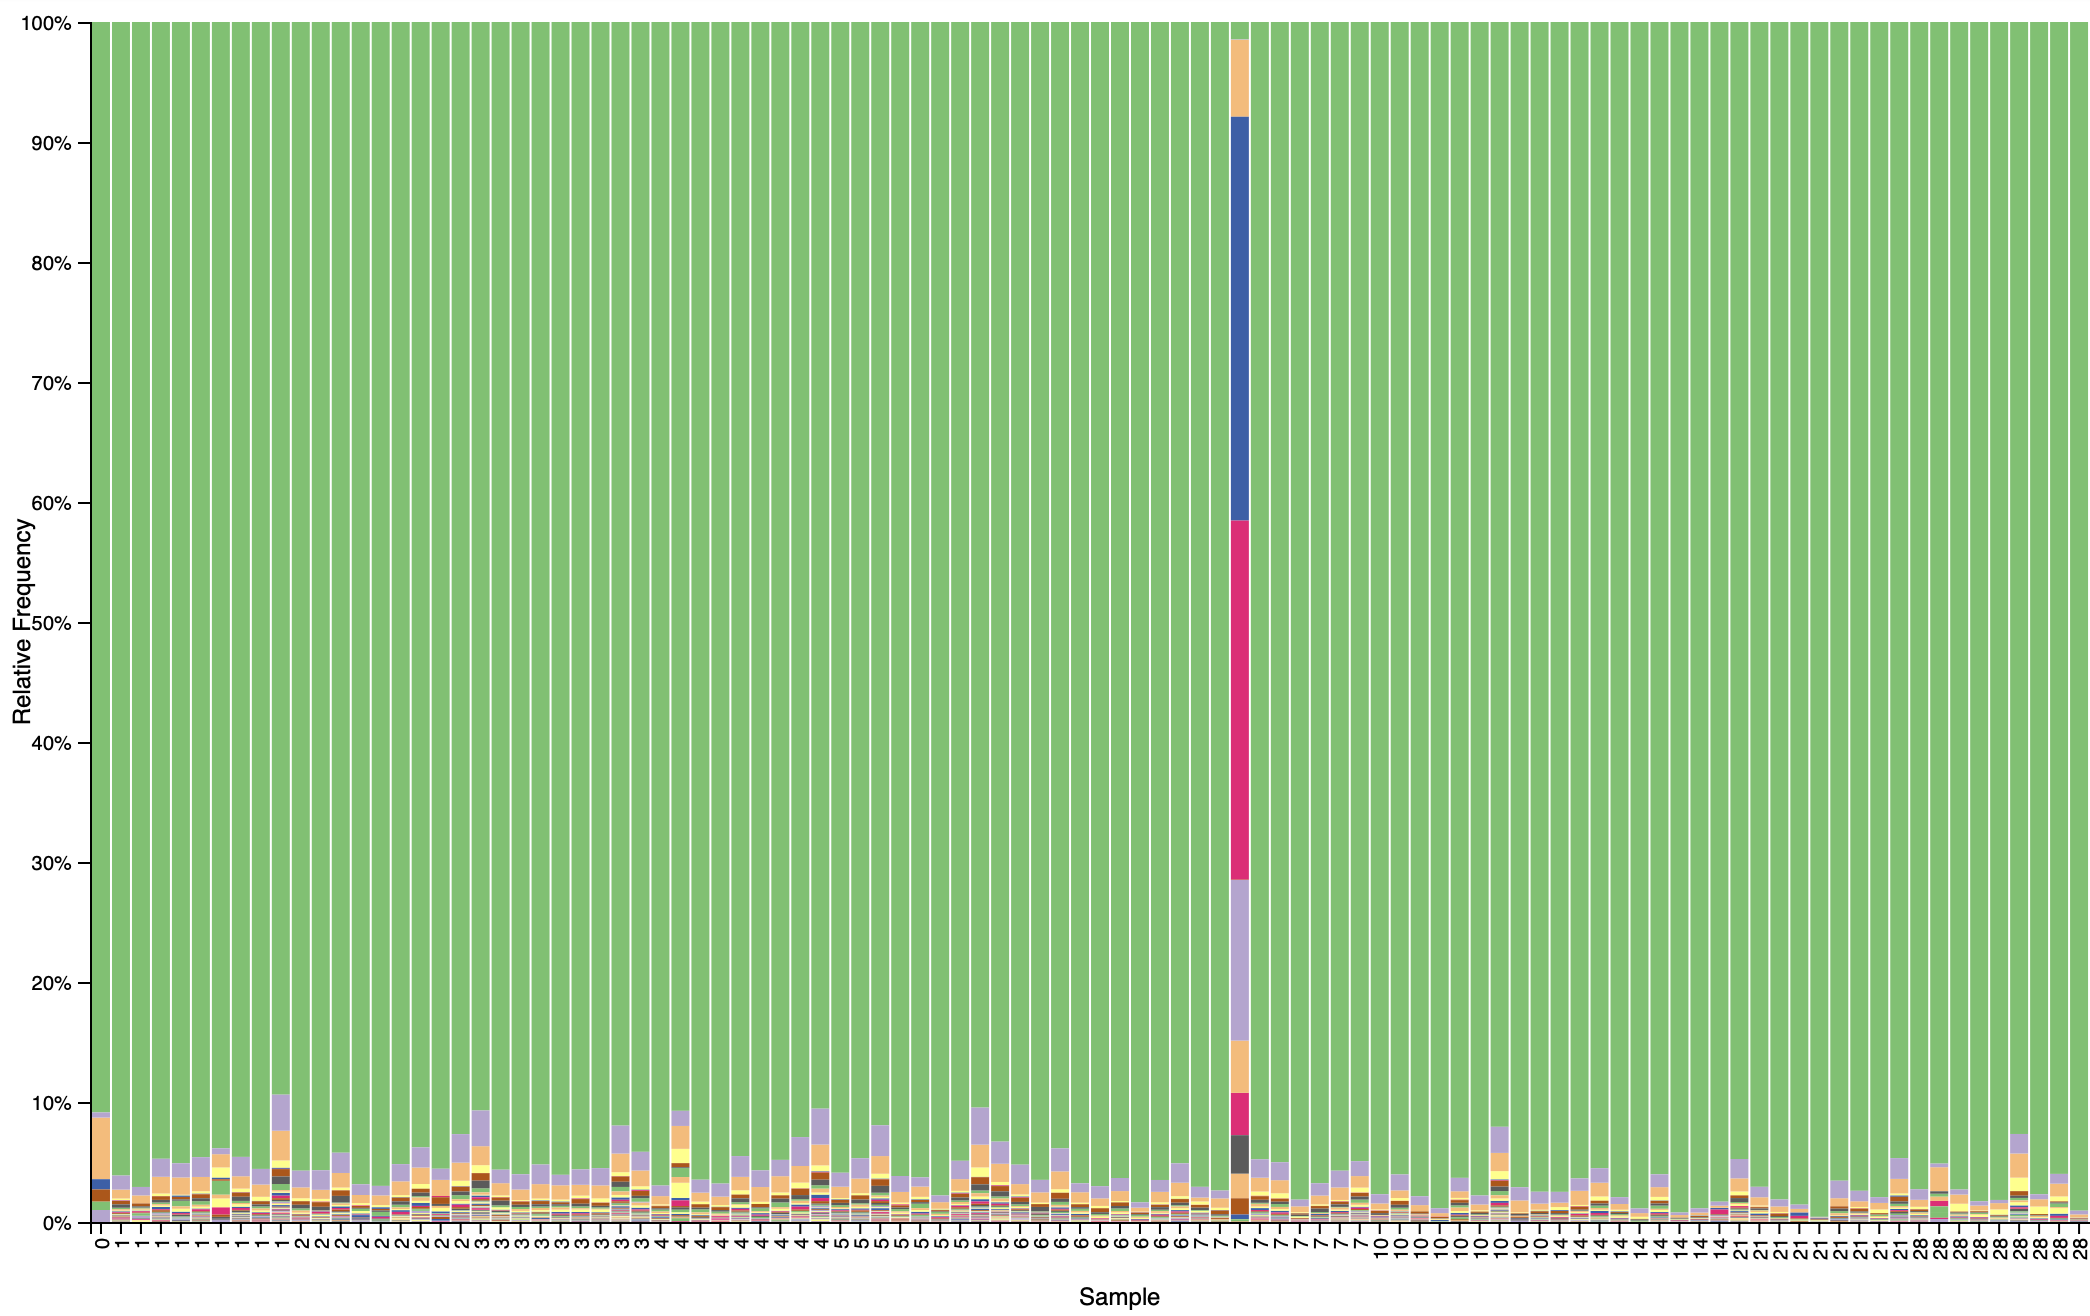

-> 1 is clearly contaminated. remove it. -> W30.03.07

In [44]:
! qiime feature-table filter-samples \
  --i-table decontam/table-fungal-all-only_my_exp.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping_no_outlier.tsv \
  --o-filtered-table decontam/table-fungai-shipping-no-out.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/table-fungai-shipping-no-out.qza


In [45]:
# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/decontam/table-fungai-shipping-no-out.qza')
taxa_bar_plots_viz, = taxa_actions.barplot(
    table=table_clean,
    taxonomy=taxonomy_artifact_sklearn,
    metadata=md,
)
taxa_bar_plots_viz.save('decontam/taxa_barplot_filt_shipping_check_no_out.qzv')

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan n

'decontam/taxa_barplot_filt_shipping_check_no_out.qzv'

-->>looks ok now.

## remove macrofungi:

In [46]:
import pandas as pd

# Load the metadata file
genera_file = "/home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/decontam/macrofungi.tsv"
genera_df = pd.read_csv(genera_file, sep='\t')

# Extract the genera column and format as a comma-separated string
genera_list = ",".join(genera_df['g__Genus'].dropna().unique())

# Print the result for use in the QIIME command
print(genera_list)

g__Bjerkandera,g__Entoloma,g__Ceratobasidium,g__Lactifluus,g__Geastrum,g__Coltricia,g__Stigmatodiscus,g__Mollisia,g__Smardaea,g__Laetisaria,g__Membranomyces,g__Gloeocantharellus,g__Chaenotheca,g__Aurantiporus,g__Marasmius,g__Inonotus,g__Typhula,g__Ramariopsis,g__Rinodina,g__Turbinellus,g__Lecidea,g__Peltigera,g__Nephroma,g__Parmotrema,g__Leotia,g__Sebacina,g__Inocybe,g__Cystolepiota,g__Leucoagaricus,g__Russula,g__Lepiota,g__Calicium,g__Volvariella,g__Genea,g__Sulzbacheromyces,g__Hallingea,g__Austrogautieria,g__Hymenogaster,g__Trichoglossum,g__Henningsomyces,g__Pustularia,g__Pectenia,g__Lycoperdon,g__Morganella,g__Leptosporomyces,g__Cortinarius,g__Tricholoma,g__Leucocoprinus,g__Coccocarpia,g__Phallus,g__Ascobolus,g__Pseudothelomma,g__Peniophora,g__Subulicystidium,g__Chaetospermum,g__Ceriporiopsis,g__Phellodon,g__Microglossum,g__Rhytidhysteron,g__Chlorociboria,g__Tephrocybella,g__Gymnopilus,g__Hyphodiscus,g__Hygrocybe,g__Physalacria,g__Hysterangium,g__Xylobolus,g__Retiarius,g__Brownliell

In [47]:
! qiime taxa filter-table \
  --i-table decontam/table-fungai-shipping-no-out.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude g__Bjerkandera,g__Entoloma,g__Ceratobasidium,g__Lactifluus,g__Geastrum,g__Coltricia,g__Stigmatodiscus,g__Mollisia,g__Smardaea,g__Laetisaria,g__Membranomyces,g__Gloeocantharellus,g__Chaenotheca,g__Aurantiporus,g__Marasmius,g__Inonotus,g__Typhula,g__Ramariopsis,g__Rinodina,g__Turbinellus,g__Lecidea,g__Peltigera,g__Nephroma,g__Parmotrema,g__Leotia,g__Sebacina,g__Inocybe,g__Cystolepiota,g__Leucoagaricus,g__Russula,g__Lepiota,g__Calicium,g__Volvariella,g__Genea,g__Sulzbacheromyces,g__Hallingea,g__Austrogautieria,g__Hymenogaster,g__Trichoglossum,g__Henningsomyces,g__Pustularia,g__Pectenia,g__Lycoperdon,g__Morganella,g__Leptosporomyces,g__Cortinarius,g__Tricholoma,g__Leucocoprinus,g__Coccocarpia,g__Phallus,g__Ascobolus,g__Pseudothelomma,g__Peniophora,g__Subulicystidium,g__Chaetospermum,g__Ceriporiopsis,g__Phellodon,g__Microglossum,g__Rhytidhysteron,g__Chlorociboria,g__Tephrocybella,g__Gymnopilus,g__Hyphodiscus,g__Hygrocybe,g__Physalacria,g__Hysterangium,g__Xylobolus,g__Retiarius,g__Brownliella,g__Hydnocristella,g__Phylloporus,g__Gerronema,g__Peziza,g__Mycena,g__Thelomma,g__Cyphelium,g__Texosporium,g__Acolium,g__Calycidium,g__Bunodophoron,g__Leifidium,g__Cornicularia,g__Platismatia,g__Clavaria,g__Pulveroboletus,g__Pulvinula,g__Umbilicaria,g__Patinella,g__Timdalia,g__Chlorophyllum,g__Clavulina,g__Cantharellus,g__Hyaloscypha,g__Tomentella,g__Durandiella,g__Pragmopora,g__Pisolithus,g__Elaphomyces,g__Ramaria,g__Tomentellopsis,g__Trechispora,g__Tretomyces,g__Coniferiporia,g__Bacidina,g__Bacidia,g__Toniniopsis,g__Conocybe,g__Cristinia,g__Lindtneria,g__Rhodocollybia,g__Rhodocybe,g__Sarcodon,g__Trichophaea,g__Rimbachia,g__Scleroderma,g__Mniaecia,g__Pezoloma,g__Mycosymbioces,g__Mutinus,g__Sclerogaster,g__Pluteus,g__Pleurotus,g__Tubulicrinis,g__Tulasnella,g__Boletus,g__Tylopilus,g__Nanoscypha,g__Efibulobasidium,g__Naematelia,g__Sistotrema,g__Sistotremastrum,g__Renatobasidium,g__Humaria,g__Scoliciosporum,g__Leucopaxillus,g__Leucophleps,g__Albatrellus,g__Mycolevis,g__Gliophorus,g__Tuber,g__Clathrus,g__Ileodictyon,g__Sanghuangporus,g__Zhuliangomyces,g__Rugosomyces,g__Parmelia,g__Scytinium,g__Leptogium,g__Macrotyphula,g__Camarophyllopsis,g__Hyphodontia,g__Gyrodontium,g__Gyroporus,g__Dactylaria,g__Lophodermium,g__Therrya,g__Tryblidiopsis,g__Coccomyces,g__Spathularia,g__Hypoderma,g__Cudonia,g__Hemileccinum,g__Calocera,g__Stereocaulon,g__Hyalorbilia,g__Stypella,g__Myxarium,g__Xenasma,g__Urceolella,g__Cistella,g__Roseodiscus,g__Hydnobolites,g__Xerocomellus,g__Humidicutis,g__Ceriporia,g__Pyrenopeziza,g__Nipterella,g__Junghuhnia,g__Hyphoderma,g__Hysterium,g__Suillus,g__Butyriboletus,g__Suillellus,g__Monacrosporium,g__Dactylellina,g__Dactylella,g__Kneiffiella,g__Amanita,g__Termitomyces,g__Urnula,g__Alpova,g__Niptera,g__Phialocephala,g__Dictyonema,g__Cyphellostereum,g__Skeletocutis,g__Athallia,g__Orientophila,g__Caloplaca,g__Calogaya,g__Polycauliona,g__Zeroviella,g__Dufourea,g__Xanthoria,g__Rusavskia,g__Corticifraga,g__Peltula,g__Hyphodermella,g__Lobaria,g__Leucoinocybe,g__Clitopilus,g__Bulbothrix,g__Pseudocyphellaria,g__Sutorius,g__Cookeina,g__Polyporus,g__Meripilus,g__Clavulinopsis,g__Propolis,g__Bonomyces,g__Hydnum,g__Baltazaria,g__Phaeocollybia,g__Myrmecocystis,g__Coprotus,g__Limonomyces,g__Marchandiobasidium,g__Maronea,g__Fuscidea,g__Phellinus,g__Peniophorella,g__Oropogon,g__Cenangiopsis,g__Rhabdocline,g__Incrucipulum,g__Marasmiellus,g__Tetrapyrgos,g__Campanella,g__Labyrinthomyces,g__Stephensia,g__Chromosera,g__Chaenothecopsis,g__Craterellus,g__Crepidotus,g__Oligoporus,g__Postia,g__Osteina,g__Poria,g__Cuphophyllus,g__Micarea,g__Biatora,g__Lamprospora,g__Dentocorticium,g__Efibula,g__Phanerochaete,g__Irpex,g__Byssomerulius,g__Cytidiella,g__Coenogonium,g__Piloderma,g__Clitocybula,g__Steccherinum,g__Atraporiella,g__Tubaria,g__Phaeomarasmius,g__Crustoderma,g__Tricharina,g__Lactarius,g__Pezicula,g__Adustochaete,g__Auricularia,g__Exidiopsis,g__Heteroradulum,g__Tremellochaete,g__Psora,g__Fomitopsis,g__Fomes,g__Helvella,g__Thaxterogaster,g__Trametes,g__Heterodermia,g__Stictis,g__Rhizocarpon,g__Agaricus,g__Morchella,g__Deconica,g__Psilocybe,g__Flammulaster,g__Orbilia,g__Rhizoctonia,g__Steinera,g__Daedalea,g__Ranadivia,g__Hypochnicium,g__Ductifera,g__Protoblastenia,g__Brianaria,g__Badimiella,g__Stephanospora,g__Thelephora,g__Pouzarella,g__Diplocystis,g__Pholiota,g__Galerina,g__Endoperplexa,g__Pseudocraterellus,g__Erythricium,g__Scabropezia,g__Clavariadelphus,g__Phaeoclavulina,g__Ampulloclitocybe,g__Strobilomyces,g__Nigroporus,g__Lecanora,g__Neodasyscypha,g__Perenniporia,g__Ganoderma,g__Megasporia,g__Amauroderma,g__Porogramme,g__Megasporoporia,g__Theleporus,g__Yuchengia,g__Lentinus,g__Dichomitus,g__Megasporoporiella,g__Epithele,g__Bresadolia,g__Daedaleopsis,g__Truncospora,g__Perenniporiella,g__Laccocephalum,g__Microporellus,g__Vanderbylia,g__Grammothele,g__Coriolopsis,g__Pyrofomes,g__Fuscoporia,g__Funalia,g__Abundisporus,g__Haddowia,g__Hexagonia,g__Diacanthodes,g__Bondarzewia,g__Neofomitella,g__Erythromyces,g__Clitocybe,g__Colospora,g__Cladia,g__Pseudevernia,g__Ramalea,g__Heterodea,g__Lasallia,g__Herteliana,g__Coltriciella,g__Fibulomyces,g__Trimmatothelopsis,g__Hyperphyscia,g__Otidea,g__Plectania,g__Cryptoporus,g__Scutellinia,g__Mollisina,g__Dermea,g__Calycina,g__Sporastatia,g__Baorangia,g__Gyalecta,g__Harrya,g__Royoporus,g__Picipes,g__Galiella,g__Dacrymyces,g__Guepiniopsis,g__Lyomyces,g__Hydnotrya,g__Blennothallia,g__Botryobasidium,g__Arrhenia,g__Athelia,g__Ruhlandiella,g__Fistulinella,g__Lecania,g__Pseudotremella,g__Wilcoxina,g__Dacryopinax,g__Absconditella,g__Cyclocybe,g__Sphaerobolus,g__Byssocorticium,g__Catillaria,g__Hysteropatella,g__Brevicellicium,g__Anomoloma,g__Cheilymenia,g__Phylloporia,g__Phellinotus,g__Stereum,g__Acanthophysellum,g__Aleurodiscus,g__Megalocystidium,g__Conferticium,g__Buellia,g__Tetramelas,g__Desmazierella,g__Mytilinidion,g__Octaviania,g__Odontia,g__Antrodia,g__Parasola,g__Macrolepiota,g__Schizophyllum,g__Trichaster,g__Radiigera,g__Ochrolechia,g__Pertusaria,g__Leptonia,g__Geopora,g__Micropsalliota,g__Maasoglossum,g__Hemimycena,g__Thanatephorus,g__Coprinus,g__Melanophyllum,g__Dictyolus,g__Hohenbuehelia,g__Hericium,g__Dentipellis,g__Laxitextum,g__Gymnomyces,g__Hymenopellis,g__Collybia,g__Cribbea,g__Hydropus,g__Lobariella,g__Dendriscosticta,g__Delastria,g__Cystoderma,g__Trichopilus,g__Pseudotomentella,g__Fuscoderma,g__Psoroma,g__Leciophysma,g__Pannaria,g__Parmeliella,g__Santessoniella,g__Gomphus,g__Bridgeoporus,g__Pterula,g__Pterulicium,g__Amylocorticiellum,g__Deflexula,g__Hydnoplicata,g__Picoa,g__Terfezia,g__Arthrobotrys,g__Opegrapha,g__Macowanites,g__Tylospora,g__Phaeotremella,g__Gymnopus,g__Saproamanita,g__Dermoloma,g__Entocybe,g__Claudopus,g__Tricholomopsis,g__Cerrena,g__Tyromyces,g__Filoboletus,g__Panellus,g__Roridomyces,g__Resinomycena,g__Lentinula,g__Tubulicium,g__Oliveonia,g__Lachnum,g__Amylascus,g__Hydnellum,g__Xeromphalina,g__Waitea,g__Hygrophoropsis,g__Limacella,g__Phyllopsora,g__Sphaerosoma,g__Austrolecia,g__Gymnohydnotrya,g__Flaviporus,g__Scytinopogon,g__Pachyella,g__Adelphella,g__Squamanita,g__Bryodina,g__Acarospora,g__Amandinea,g__Candelaria,g__Thelotrema,g__Meruliporia,g__Hypohelion,g__Cantharellula,g__Moellerodiscus,g__Ciboria,g__Fuscolachnum,g__Trichaptum,g__Gyromitra,g__Discina,g__Pilophorus,g__Cystostereum,g__Retiboletus,g__Mycoacia,g__Simocybe,g__Diplocarpon,g__Punctelia,g__Xanthoparmelia,g__Austroparmelina,g__Sidera,g__Violella,g__Halecania,g__Catinaria,g__Fellhanera,g__Panus,g__Chondrostereum,g__Rhizochaete,g__Ionomidotis,g__Gomphillus,g__Anisomeridium,g__Pseudobaeospora,g__Pyxine,g__Anthracobia,g__Lachnocladium,g__Sarcogyne,g__Polysporina,g__Haloplaca,g__Agyrium,g__Chrysothrix,g__Calathella,g__Ripartites,g__Destuntzia,g__Phlebiopsis,g__Panaeolus,g__Letrouitia,g__Imleria,g__Alloclavaria,g__Dactylosporina,g__Choiromyces,g__Echinoderma,g__Cyanodermella,g__Rectipilus,g__Pyrrhoderma,g__Pseudohydnum,g__Flammulina,g__Arpinia,g__Nolanea,g__Cryptomarasmius,g__Plicaria,g__Neonothopanus,g__Omphalotus,g__Scytinostroma,g__Vararia,g__Lachnopsis,g__Lachnellula,g__Myxariellum,g__Microstoma,g__Toninia,g__Kiliasia,g__Physisporinus,g__Henningsia,g__Chloroscypha,g__Krogia,g__Leccinum,g__Inocephalus,g__Graphis,g__Pyrgillus,g__Tremolecia,g__Carassea,g__Pycnothelia,g__Neofavolus,g__Gloeophyllum,g__Eschatogonia,g__Rhizopogon,g__Cerinomyces,g__Cheimonophyllum,g__Crinipellis,g__Coprinopsis,g__Lentinellus,g__Lentaria,g__Arctomia,g__Earliella,g__Tarzetta,g__Diploschistes,g__Lethariella,g__Parmelina,g__Usnea,g__Myelochroa,g__Protousnea,g__Protoparmelia,g__Parmelaria,g__Hypogymnia,g__Arctocetraria,g__Carbonicola,g__Allocetraria,g__Ahtiana,g__Melanohalea,g__Hypotrachyna,g__Psilolechia,g__Cetrariella,g__Nipponoparmelia,g__Brodoa,g__Crespoa,g__Cetrelia,g__Melanelia,g__Nephromopsis,g__Cetraria,g__Karoowia,g__Montanelia,g__Rhizoplaca,g__Melanelixia,g__Bryoria,g__Allantoparmelia,g__Omphalodiella,g__Evernia,g__Menegazzia,g__Arctoparmelia,g__Mycoblastus,g__Dolichousnea,g__Flavoparmelia,g__Notoparmelia,g__Everniopsis,g__Vulpicida,g__Sagiolechia,g__Cyptotrama,g__Ameghiniella,g__Meruliopsis,g__Fuscopannaria,g__Kroswia,g__Veluticeps,g__Antrodiella,g__Basidiodendron,g__Trichopezizella,g__Lasiobelonium,g__Aleurina,g__Sirenophila,g__Mycocalicium,g__Phaeocalicium,g__Dingleya,g__Afroboletus,g__Dirinaria,g__Hygrophorus,g__Porpoloma,g__Dentipellicula,g__Pachyphlodes,g__Protomerulius,g__Drepanopeziza,g__Marssonina,g__Blumeriella,g__Dirina,g__Xanthagaricus,g__Hymenagaricus,g__Biatoridium,g__Anzina,g__Arthrorhaphis,g__Smithiomyces,g__Austroboletus,g__Cystoagaricus,g__Amyloathelia,g__Josefpoeltia,g__Abortiporus,g__Cymatoderma,g__Mallocybe,g__Lacrymaria,g__Phaeophyscia,g__Physciella,g__Miriquidica,g__Trapelia,g__Rimularia,g__Xylographa,g__Lithographa,g__Trapeliopsis,g__Lambiella,g__Placopsis,g__Cibaomyces,g__Pleurocybella,g__Anzia,g__Steinia,g__Zelleromyces,g__Franwilsia,g__Galerella,g__Candelabrochaete,g__Rutstroemia,g__Torrendiella,g__Unguiculella,g__Unguiculariopsis,g__Infundibulicybe,g__Camarophyllus,g__Boidinia,g__Protodaedalea,g__Chondrogaster,g__Gummiglobus,g__Castoreum,g__Pistillaria,g__Grifola,g__Lopharia,g__Radulomyces,g__Marchantiana,g__Laccaria,g__Tulostoma,g__Fibroporia,g__Bourdotia,g__Jasonhuria,g__Lepidostroma,g__Perrotia,g__Albotricha,g__Capitotricha,g__Leucangium,g__Byssolecania,g__Calopadia,g__Pseudoplectania,g__Ramboldia,g__Candelariella,g__Nigrofomes,g__Hysterobrevium,g__Aureoboletus,g__Boletellus,g__Flagelloscypha,g__Dendrothele,g__Coprinellus,g__Cejpia,g__Vibrissea,g__Hysteronaevia,g__Xerocomus,g__Neoboletus,g__Clarkeinda,g__Cerioporus,g__Fomitiporella,g__Rhodophana,g__Phloeomana,g__Resinicium,g__Ricasolia,g__Pycnora,g__Amylosporus,g__Chlorencoelia,g__Bulgariella,g__Austropaxillus,g__Haploporus,g__Bactrospora,g__Thalloidima,g__Octospora,g__Resupinatus,g__Rossbeevera,g__Marcelleina,g__Phlebia,g__Dictyocephalos,g__Chlamydopus,g__Gelatinodiscus,g__Rubroboletus,g__Lanmaoa,g__Hyalopeziza,g__Acanthophysium,g__Aleurocystidiellum,g__Clitopilopsis,g__Podoscypha,g__Ramalina,g__Niebla,g__Stirtoniella,g__Cliostomum,g__Tylothallia,g__Schaereria,g__Heppia,g__Ploioderma,g__Rickenella,g__Physcia,g__Myriostoma,g__Microporus,g__Hysteropezizella,g__Eocronartium,g__Limnoperdon,g__Cryptodiscus,g__Flavoplaca,g__Marthamyces,g__Naemacyclus,g__Physconia,g__Anaptychia,g__Oxnerella,g__Rinodinella,g__Pseudolaccaria,g__Baeomyces,g__Melanomphalia,g__Pholiotina,g__Protomicarea,g__Candelina,g__Placomaronea,g__Strangospora,g__Punctularia,g__Phlyctis,g__Staurolemma,g__Rhymbocarpus,g__Dichostereum,g__Phaeohelotium,g__Bisporella,g__Hymenoscyphus,g__Megacollybia,g__Erioscyphella,g__Belonidium,g__Trichopeziza,g__Phyllobolites,g__Solenopsora,g__Callistosporium,g__Pleurocollybia,g__Lenzites,g__Sowerbyella,g__Gorgoniceps,g__Follmannia,g__Pachyphloeus,g__Hydnoporia,g__Abrothallus,g__Aleuria,g__Bolbitius,g__Pulchroboletus,g__Cyathus,g__Dacryobolus,g__Xylodon,g__Agrocybe,g__Plicaturopsis,g__Hapalopilus,g__Neolentinus,g__Loxospora,g__Argopsis,g__Favolaschia,g__Cruentomycena,g__Cynema,g__Calocybe,g__Pyrgidium,g__Echinochaete,g__Ocellularia,g__Gymnopaxillus,g__Omphalina,g__Haematomma,g__Psathyrella,g__Porpidia,g__Chalciporus,g__Genabea,g__Scopuloides,g__Acrocordia,g__Cryptohymenium,g__Densocarpa,g__Tympanis,g__Claussenomyces,g__Dimelaena,g__Helicogloea,g__Tapinella,g__Acervus,g__Inocutis,g__Sclerococcum,g__Aphroditeola,g__Fissurina,g__Gloiocephala,g__Hortiboletus,g__Tremiscus,g__Relicina,g__Himantormia,g__Amylocystis,g__Metulochaete,g__Austroplaca,g__Xanthocarpia,g__Xanthopeltis,g__Pachypeltis,g__Gondwania,g__Parvoplaca,g__Golubkovia,g__Canoparmelia,g__Lecidella,g__Lyophyllum,g__Pseudoomphalina,g__Multifurca,g__Tubosaeta,g__Arthonia,g__Coniophora,g__Rhytisma,g__Ionosporus,g__Wrightoporia,g__Exidia,g__Crocicreas,g__Lawreyella,g__Heimiomyces,g__Lasioloma,g__Gallacea,g__Phaeographis,g__Platygramme,g__Huangshania,g__Triblidium,g__Sclerotinia,g__Megalospora,g__Fulvifomes,g__Calostoma,g__Lambertella,g__Eilifdahlia,g__Caloboletus,g__Gymnogaster,g__Porpolomopsis,g__Brigantiaea,g__Epulorhiza,g__Skyttea,g__Dictyophora,g__Xanthoporia,g__Phaeolus,g__Rhizomarasmius,g__Gloniopsis,g__Rigidoporus,g__Naiadolina,g__Elenkiniana,g__Astraeus,g__Gerhardtia,g__Neoprotoparmelia,g__Luteoamylascus,g__Sphaeropezia,g__Geoglossum,g__Stropharia,g__Hypholoma,g__Pezizella,g__Ramsbottomia,g__Pleopsidium,g__Monilinia,g__Ciborinia,g__Helvellosebacina,g__Hornodermoporus,g__Parvixerocomus,g__Pseudoparmelia,g__Arachnion,g__Verpa,g__Diploicia,g__Xalocoa,g__Sagenidiopsis,g__Microthyrium,g__Rimelia,g__Parmelinella,g__Myrionora,g__Phellopilus,g__Glyphium,g__Asteristion,g__Eremiomyces,g__Amicodisca,g__Dicranidion,g__Ropalospora,g__Imperator,g__Sebipora,g__Cinereomyces,g__Bryoglossum,g__Eleutherascus,g__Neofabraea,g__Phialea,g__Neocudoniella,g__Scleropezicula,g__Badimia,g__Heimioporus,g__Bivallum,g__Malmidea,g__Trogia,g__Porotheleum,g__Lepra,g__Rhodofomes,g__Ceraceomyces,g__Metulodontia,g__Sarcographa,g__Reichlingia,g__Phyllobaeis,g__Gautieria,g__Melanoleuca,g__Phylloporopsis,g__Soleella,g__Bryostigma,g__Polydiscidium,g__Byssoloma,g__Gelatinopsis,g__Iodophanus,g__Glyphis,g__Paralepistopsis,g__Teloschistes,g__Acanthothecis,g__Neohygrocybe,g__Roccellina,g__Balsamia,g__Hirticlavula,g__Omphalora,g__Auritella,g__Laetinaevia,g__Discinella,g__Lotinia,g__Gamundia,g__Conchomyces,g__Lichenomphalia,g__Buglossoporus,g__Cystodermella,g__Volvopluteus,g__Wirthiotrema,g__Sarcosphaera,g__Chlorovibrissea,g__Polyozellus,g__Australiaena,g__Serpula,g__Fomitiporia,g__Tropicoporus,g__Xerula,g__Diplocarpa,g__Plicariella,g__Sarcoporia,g__Neobulgaria,g__Ascocoryne,g__Paurocotylis,g__Carcinomyces,g__Icmadophila,g__Arambarria,g__Crustomyces,g__Athelopsis,g__Neournula,g__Tremellodendropsis,g__Gyalidea,g__Patellaria,g__Gomphidius,g__Ceratorhiza,g__Rhizodiscina,g__Petractis,g__Mucronella,g__Ionaspis,g__Pseudowrightoporia,g__Hydnophlebia,g__Armillaria,g__Heterochaete,g__Tapellaria,g__Sericeomyces,g__Macrocybe,g__Neopaxillus,g__Gloeodontia,g__Chroogomphus,g__Trochila,g__Heyderia,g__Crumenulopsis,g__Calyptella,g__Campanophyllum,g__Diplotomma,g__Varicellaria,g__Sphinctrina,g__Placynthiella,g__Albomagister,g__Scutula,g__Catinella,g__Physma,g__Puttea,g__Lathagrium,g__Fellhaneropsis,g__Caloscypha,g__Chromocyphella,g__Grovesiella,g__Tricholosporum,g__Pleuroflammula,g__Climacodon,g__Delicatula,g__Davisomycella,g__Phaeophlebiopsis,g__Porostereum,g__Wolfiporia,g__Dermatiscum,g__Chaetocalathus,g__Xenasmatella,g__Caripia,g__Cyanoboletus,g__Laetiporus,g__Cleistocybe,g__Auriscalpium,g__Enterographa,g__Coniolepiota,g__Timgrovea,g__Descomyces,g__Sclerophora,g__Cyttaria,g__Calycellina,g__Unguicularia,g__Hygroaster,g__Spongipellis,g__Gyrophanopsis,g__Amphinema,g__Degeliella,g__Trichobolus,g__Parakarstenia,g__Cantharocybe,g__Fibrodontia,g__Rugiboletus,g__Porphyrellus,g__Clitocella,g__Niveoporofomes,g__Spilonema,g__Squamarina,g__Cladonia,g__Gymnoderma,g__Gibbosporina,g__Polychidium,g__Tremellodendron,g__Tremelloscypha,g__Phacidium,g__Neottiella,g__Lactocollybia,g__Moniliophthora,g__Lanzia,g__Gypsoplaca,g__Pannoparmelia,g__Leptocorticium,g__Aegis,g__Multiclavula,g__Royoungia,g__Mesophellia,g__Malajczukia,g__Chlorosplenium,g__Loweomyces,g__Sarcosagium,g__Gyalolechia,g__Corticium,g__Crustodontia,g__Pseudolagarobasidium,g__Cytidia,g__Vuilleminia,g__Protounguicularia,g__Piccolia,g__Gyalideopsis,g__Tubariomyces,g__Navisporus,g__Ossicaulis,g__Ostreichnion,g__Micropodia,g__Alnicola,g__Spirographa,g__Gloeoheppia,g__Richoniella,g__Gamsylella,g__Olla,g__Psilocistella,g__Atheniella,g__Mycopan,g__Laternea,g__Aseroe,g__Mucidula,g__Pseudofavolus,g__Podofomes,g__Datronia,g__Sporopodium,g__Aspicilia,g__Koerberiella,g__Bellemerea,g__Lecidoma,g__Immersaria,g__Xanthoconium,g__Leucogaster,g__Farnoldia,g__Remototrachyna,g__Proterochaete,g__Eichleriella,g__Amphistereum,g__Larssoniporia,g__Gloeoporus,g__Nothocastoreum,g__Rhopalogaster,g__Oudemansiella,g__Tephrocybe,g__Artomyces,g__Clarireedia,g__Poculum,g__Vermispora,g__Leucophellinus,g__Lecophagus,g__Allophylaria,g__Austropezia,g__Rodwayella,g__Disciotis,g__Corneriella,g__Gloiothele,g__Skvortzovia,g__Tephromela,g__Calvitimela,g__Martininia,g__Tassiloa,g__Villophora,g__Phacopsis,g__Cetrariastrum,g__Everniastrum,g__Nodobryoria,g__Hebeloma,g__Mattirolomyces,g__Phlebopus,g__Schizoxylon,g__Cresponea,g__Alyxoria,g__Colpoma,g__Collema,g__Gyrodon,g__Melanogaster,g__Sarcoscypha,g__Cystangium,g__Pithya,g__Amylostereum,g__Cora,g__Bryobilimbia,g__Namakwa,g__Boubovia,g__Mycobilimbia,g__Mycenella,g__Chaetomella,g__Pilidium,g__Amaurodon,g__Pseudomerulius,g__Schizostoma,g__Myriotrema,g__Hydrocina,g__Drechslerella,g__Resinoporia,g__Rhodonia,g__Pycnoporellus,g__Nidula,g__Sarea,g__Protodontia,g__Podaxis,g__Neoalbatrellus,g__Holmiella,g__Ripartitella,g__Ascotremella,g__Hodophilus,g__Onnia,g__Sculptolumina,g__Australohydnum,g__Hyphodontiella,g__Lobothallia,g__Circinaria,g__Sagedia,g__Megaspora,g__Bibbya,g__Sporacestra,g__Basidioradulum,g__Radulodon,g__Poeltidea,g__Amygdalaria,g__Phillipsia,g__Favolus,g__Gloeocystidiellum,g__Marchandiomyces,g__Leccinellum,g__Upretia,g__Ioplaca,g__Microscypha,g__Litschauerella,g__Asterostroma,g__Monascella,g__Trulla,g__Carbonea,g__Yoshimuria,g__Metuloidea,g__Pyronema,g__Hymenochaete,g__Datroniella,g__Microcalicium,g__Flabellophora,g__Anthracophyllum,g__Lepista,g__Crassisporium,g__Blastenia,g__Catathelasma,g__Niorma,g__Aroramyces,g__Placolecis,g__Rufoplaca,g__Paralecia,g__Xerophorus,g__Phaeopterula,g__Myrmecopterula,g__Meloderma,g__Nematococcomyces,g__Degelia,g__Sticta,g__Dibaeis,g__Calocybella,g__Palicella,g__Pusillomyces,g__Entomocorticium,g__Chapsa,g__Phaeomyces,g__Hypsizygus,g__Dicephalospora,g__Cotylidia,g__Hemileucoglossum,g__Sphaerosporella,g__Austroblastenia,g__Megaloblastenia,g__Atractosporocybe,g__Odonticium,g__Acanthocorticium,g__Xanthoporus,g__Kurtia,g__Amylocorticium,g__Neolentiporus,g__Mycoamaranthus,g__Scutaria,g__Usnochroma,g__Catenarina,g__Wetmoreana,g__Shackletonia,g__Cerothallia,g__Teloschistopsis,g__Botryotinia,g__Caeruleum,g__Tremellogaster,g__Stereopsis,g__Clavulicium,g__Phellinopsis,g__Rhodoscypha,g__Kavinia,g__Ramaricium,g__Verrucospora,g__Dennisiomyces,g__Asproinocybe,g__Cercopemyces,g__Mycetinis,g__Ombrophila,g__Brunnipila,g__Tatraea,g__Endoscypha,g__Cudoniella,g__Schenella,g__Amphosoma,g__Kuehneromyces,g__Flammula,g__Geopyxis,g__Arthromyces,g__Graddonia,g__Dasyscyphella,g__Trichophaeopsis,g__Psilachnum,g__Flavopunctelia,g__Boletopsis,g__Peccania,g__Roccella,g__Trichaleurina,g__Gelacantha,g__Barssia,g__Arctopeltis,g__Myriolecis,g__Protoparmeliopsis,g__Adelolecia,g__Hertelidea,g__Palifer,g__Echinoporia,g__Gilkeya,g__Brachyphoris,g__Fulgensia,g__Bryoscyphus,g__Symphyosirinia,g__Gloeotinia,g__Alessioporus,g__Bachmanniomyces,g__Typhrasa,g__Alboleptonia,g__Singerocybe,g__Broomeia,g__Singerocomus,g__Banhegyia,g__Melaspileella,g__Dyplolabia,g__Mayamontana,g__Pirottaea,g__Relicinopsis,g__Ainoa,g__Lysurus,g__Anomoporia,g__Punctulariopsis,g__Battarrea,g__Microdochiella,g__Amyloxenasma,g__Lobulicium,g__Buelliella,g__Sarcoleotia,g__Nothomitra,g__Acanthobasidium,g__Enchylium,g__Merismodes,g__Macrocystidia,g__Diplonaevia,g__Incrupila,g__Podoserpula,g__Aquadiscula,g__Squamulea,g__Pseudopeziza,g__Helicoon,g__Hamatocanthoscypha,g__Hymenogloea,g__Disciseda,g__Calvatia,g__Bovista,g__Holocotylon,g__Vascellum,g__Neoantrodia,g__Purpureocorticium,g__Clauzadea,g__Solorina,g__Mycocalia,g__Fasciodontia,g__Heterobasidion,g__Floccularia,g__Astrosporina,g__Amarrendia,g__Dermocybe,g__Roccellaria,g__Itajahya,g__Protubera,g__Coccotrema,g__Pyrenodesmia,g__Variospora,g__Seirophora,g__Kriegeria,g__Glutinoglossum,g__Arachnopeziza,g__Durella,g__Phanerodontia,g__Terana,g__Flavodon,g__Strobilurus,g__Bapalmuia,g__Lecanographa,g__Santessonia,g__Lignosus,g__Spongiforma,g__Dichopleuropus,g__Duebenia,g__Banksiamyces,g__Flavocetraria,g__Hoffmannoscypha,g__Halegrapha,g__Hymenelia,g__Poeltinula,g__Phellorinia,g__Caudicicola,g__Placynthium,g__Metus,g__Dendrographa,g__Bilimbia,g__Biatorella,g__Irpiciporus,g__Neomensularia,g__Ungulidaedalea,g__Pseudoarmillariella,g__Redonographa,g__Vezdaea,g__Pellidiscus,g__Inonotopsis,g__Hafellia,g__Bryonora,g__Hypochniciellum,g__Lopadium,g__Calloriopsis,g__Synarthonia,g__Pyrenopsis,g__Descolea,g__Scotomyces,g__Underwoodia,g__Lichinella,g__Amyloporia,g__Arthothelium,g__Chrysomphalina,g__Murangium,g__Calliderma,g__Japewiella,g__Dendrominia,g__Bryoclaviculus,g__Lepidocollema,g__Octosporopsis,g__Sphaerobasidium,g__Pyrrhospora,g__Epithelopsis,g__Schizotrema,g__Carolinigaster,g__Protohydnum,g__Haloaleurodiscus,g__Rhodofomitopsis,g__Polyporoletus,g__Boreostereum,g__Repetobasidium,g__Saccosoma,g__Aquapeziza,g__Dentipellopsis,g__Leptochidium,g__Siphulella,g__Crucibulum,g__Incrustocalyptella,g__Gelatoporia,g__Sarcosoma,g__Ertzia,g__Orphniospora,g__Porodisculus,g__Baculifera,g__Wrightoporiopsis,g__Psilochaete,g__Gyalectaria,g__Lyoathelia,g__Psiloglonium,g__Haplotrichum,g__Schizopora,g__Orbiliopsis,g__Cyanosporus,g__Episphaeria,g__Wadeana,g__Duportella,g__Rolfidium,g__Psoronactis,g__Pseudosclerococcum,g__Pseudolasiobolus,g__Lophomerum,g__Cashiella,g__Macroskyttea,g__Tarasginia,g__Australopilus,g__Burrowsia,g__Tridentaria,g__Simonyella,g__Lecanactis,g__Oedohysterium,g__Psorotichia,g__Carbacanthographis,g__Hydnotryopsis,g__Megalaria,g__Asterothyrium,g__Nothojafnea,g__Lulesia,g__Lirula,g__Rickiella,g__Llimoniella,g__Digitatispora,g__Poeltiaria,g__Meiorganum,g__Dendrocorticium,g__Halocyphina,g__Austrotrema,g__Aleurocystis,g__Setulipes,g__Pterygiopsis,g__Inoderma,g__Sporodophoron,g__Corditubera,g__Fistulina,g__Zangia,g__Gintarasia,g__Ramalodium,g__Pentagenella,g__Physcidia,g__Knightiella,g__Ischnoderma,g__Loxosporopsis,g__Cruentotrema,g__Cyphella,g__Mobergia,g__Asterodon,g__Clitolyophyllum,g__Leucoglossum,g__Lachnella,g__Sepultariella,g__Leucogyrophana,g__Paralepista,g__Tholurna,g__Allocalicium,g__Tephroderma,g__Thuemenidium,g__Huneckia,g__Polydesmia,g__Porpomyces,g__Stellarangia,g__Phellinidium,g__Acroscyphus,g__Oxyporus,g__Guyanagarika,g__Ophioparma,g__Fulgidea,g__Myriospora,g__Hypocenomyce,g__Xylopsora,g__Elixia,g__Melastiza,g__Chaetothiersia,g__Micraspis,g__Trappea,g__Rhizocybe,g__Clavicorona,g__Pachycudonia,g__Heliogaster,g__Rheubarbariboletus,g__Neoaleurodiscus,g__Hastodontia,g__Atractocolax,g__Crocinoboletus,g__Boletinellus,g__Incrustoporia,g__Lazarenkoella,g__Langeottia,g__Pirex,g__Byssoporia,g__Pseudoboletus,g__Patellariopsis,g__Protoglossum,g__Turmalinea,g__Sarcotrochila,g__Brunneocorticium,g__Mitrula,g__Fuscopostia,g__Cystidiopostia,g__Spongiporus,g__Luteoporia,g__Tympanella,g__Hemistropharia,g__Stamnaria,g__Cupulina,g__Sclerotrema,g__Lauriliella,g__Flavidoporia,g__Melanoporia,g__Tinctoporellus,g__Cellypha,g__Donkioporia,g__Perenniporiopsis,g__Foraminispora,g__Sparsitubus,g__Diplomitoporus,g__Fomitella,g__Szczepkamyces,g__Australoporus,g__Donadinia,g__Bulgaria,g__Ovealmbornia,g__Guepinia,g__Termiticola,g__Coniocarpon,g__Spooneromyces,g__Aspilidea,g__Mycenastrum,g__Chamaeota,g__Hydnomerulius,g__Montagnea,g__Ceratellopsis,g__Protoxerula,g__Ponticulomyces,g__Yoshimuriella,g__Psorophorus,g__Coronicium,g__Merulicium,g__Cazia,g__Tirmania,g__Gyrographa,g__Sarcodontia,g__Xerombrophila,g__Melaspilea,g__Contumyces,g__Lepidotia,g__Dacryoscyphus,g__Bothia,g__Pterygellus,g__Bifusella,g__Venturiocistella,g__Pleurotopsis,g__Jamesiella,g__Gloeostereum,g__Borofutus,g__Deltopyxis,g__Mucilopilus,g__Kalapuya,g__Gloeopeniophorella,g__Physodontia,g__Pseudotulostoma,g__Harmajaea,g__Clitopaxillus,g__Musumecia,g__Pogonoloma,g__Notholepista,g__Pseudoclitocybe,g__Panaeolina,g__Lenzitopsis,g__Seticyphella,g__Connopus,g__Sarcopeziza,g__Anupama,g__Dextrinocystis,g__Luellia,g__Calongea,g__Waynea,g__Boreoplaca,g__Hosseusiella,g__Japewia,g__Melanoderma,g__Femsjonia,g__Deviodontia,g__Eumitria,g__Emodomelanelia,g__Nesolechia,g__Dactylina,g__Alectoria,g__Bryocaulon,g__Letharia,g__Pseudephebe,g__Usnocetraria,g__Pleurosticta,g__Parmeliopsis,g__Tuckermanella,g__Cetreliopsis,g__Parmelinopsis,g__Kaernefeltia,g__Imshaugia,g__Unilacryma,g__Cordierites,g__Athelicium,g__Pseudomitrula,g__Hourangia,g__Neolecta,g__Lycogalopsis,g__Laccariopsis,g__Pseudoxenasma,g__Stecchericium,g__Homophron,g__Schismatomma,g__Taiwanofungus,g__Porodaedalea,g__Phyllotopsis,g__Pseudosarcosoma,g__Mycoleptodonoides,g__Xeropilidium,g__Schildia,g__Endocena,g__Tornabea,g__Paraxerula,g__Aphanobasidium,g__Lamelloclavaria,g__Ocellomma,g__Coronellaria,g__Kombocles,g__Restingomyces,g__Citripora,g__Phylliscum,g__Hypotarzetta,g__Combea,g__Hubbsia,g__Exsudoporus,g__Truncocolumella,g__Cupreoboletus,g__Strossmayeria,g__Trullella,g__Namibialina,g__Tylocliostomum,g__Topeliopsis,g__Kashiwadia,g__Cyclaneusma,g__Phaeorrhiza,g__Amparoina,g__Parainoa,g__Leifia,g__Chorioactis,g__Proliferodiscus,g__Solenopezia,g__Psilopezia,g__Jafnea,g__Buchwaldoboletus,g__Verkleyomyces,g__Pseudohelotium,g__Hymenochaetopsis,g__Orceolina,g__Dendrocollybia,g__Monilia,g__Cylindrobasidium,g__Merulius,g__Heliocybe,g__Chaetodermella,g__Pycnoporus,g__Scytinostromella,g__Pseudolepiota,g__Hemipholiota,g__Mycoaciella,g__Botryohypochnus,g__Claviradulomyces,g__Oxneria,g__Dijigiella,g__Xanthomendoza,g__Teuvoahtiana,g__Pyropyxis,g__Pseudaleuria,g__Sinohygrocybe,g__Cantharellopsis,g__Pseudoporpoloma,g__Romjularia,g__Rhodotus,g__Leiorreuma,g__Ptychographa,g__Mensularia,g__Binderoboletus,g__Diehliomyces,g__Suillosporium,g__Mycorrhaphium,g__Leratiomyces,g__Phaeonematoloma,g__Protostropharia,g__Glypholecia,g__Piceomphale,g__Kohninia,g__Pseudofibroporia,g__Maireina,g__Rommelaarsia,g__Obba,g__Perplexostereum,g__Leucopholiota,g__Wolfina,g__Paulisebacina,g__Atheloderma,g__Pseudoclitopilus,g__Geodina,g__Rhizina,g__Gloeohypochnicium,g__Pseudoinonotus,g__Chrysodisca,g__Carbomyces,g__Pseudopezicula,g__Naevala,g__Pseudotricharina,g__Paratricharina,g__Gloeosoma,g__Vahliella,g__Myxomphalia,g__Sarcomyxa,g__Radulotubus,g__Stypellopsis,g__Chamonixia,g__Xanthopsoroma,g__Gloeoporellus,g__Pseudographis,g__Stagnicola,g__Babosia,g__Cystidiodontia,g__Leptoporus,g__Elderia,g__Geesterania,g__Phlebiporia,g__Boletinus,g__Cenangium,g__Mycosphaerangium,g__Gremmeniella,g__Godronia,g__Granulobasidium,g__Uncobasidium,g__Pycnopulvinus,g__Alutaceodontia,g__Amaropostia,g__Kalaharituber,g__Lichina,g__Roseograndinia,g__Auriporia,g__Gregorella,g__Geniculifera,g__Macrohyporia,g__Haasiella,g__Loramyces,g__Obtectodiscus,g__Gloiodon,g__Setigeroclavula,g__Chrysomycena,g__Glaziella,g__Setchelliogaster,g__Holwaya,g__Gelatinipulvinella,g__Pseudophacidium,g__Mycoclelandia,g__Pleuromyces,g__Lasiobolus,g__Ditiola,g__Caulorhiza,g__Baeospora,g__Pleurella,g__Indoporus,g__Rubellofomes,g__Muscinupta,g__Thyrea,g__Massalongia,g__Imaia,g__Loekoesia,g__Gigasperma,g__Paullicorticium,g__Piptoporellus,g__Hypochnella,g__Elmerina,g__Aporpium,g__Loreleia,g__Protoacia,g__Bloxamia,g__Climacocystis,g__Gloioxanthomyces,g__Mycaureola,g__Sulcaria,g__Leightoniella,g__Taitaia,g__Veloporphyrellus,g__Leimonis,g__Pachylepyrium,g__Rubinoboletus,g__Boudiera,g__Australovuilleminia,g__Sabuloglossum,g__Eriocybe,g__Tricholomella,g__Spongispora,g__Trichoramalina,g__Jahnoporus,g__Durianella,g__Blumenavia,g__Costatisporus,g__Pseudopithyella,g__Gymnographopsis,g__Pseudomegasporoporia,g__Mycobonia,g__Gyalectidium,g__Heinemannomyces,g__Fuscoboletinus,g__Stromatinia,g__Scleromitrula,g__Dencoeliopsis,g__Hermanssonia,g__Jaapia,g__Kukwaea,g__Remleria,g__Asperopilum,g__Pseudotryblidium,g__Micropeziza,g__Dextrinoporus,g__Gelatinomyces,g__Schistophoron,g__Chamaemyces,g__Asahinea,g__Frutidella,g__Kaernefia,g__Thelliana,g__Masonhalea,g__Esslingeriana,g__Jansia,g__Rhodotarzetta,g__Paragymnopus,g__Pulverulina,g__Zwackhia,g__Pseudoschismatomma,g__Ascodesmis,g__Amylocarpus,g__Wynnea,g__Joergensenia,g__Paragyrodon,g__Mycoceros,g__Scutiger,g__Nidulariopsis,g__Parascutellinia,g__Echinodontium,g__Echinodontiellum,g__Corella,g__Lophodermella,g__Albatrellopsis,g__Arcangeliella,g__Sphaerographium,g__Zoellneria,g__Porpidinia,g__Jimtrappea,g__Neoalpova,g__Trichocybe,g__Plicatura,g__Irpicodon,g__Redheadia,g__Myriosclerotinia,g__Sclerencoelia,g__Streptotinia,g__Dumontinia,g__Valdensinia,g__Pycnopeziza,g__Elliottinia,g__Encoelia,g__Fibricium,g__Lentoporia,g__Nidularia,g__Ofella,g__Ditangium,g__Anamylopsora,g__Desarmillaria,g__Gemmina,g__Heteroacanthella,g__Erastia,g__Antella,g__Butyrea,g__Dacryonaema,g__Hydnangium,g__Fayodia,g__Mythicomyces,g__Romagnesiella,g__Fauriea,g__Erythrophylloporus,g__Gastrosporium,g__Stouffera,g__Dendriscocaulon,g__Atrophysma,g__Parapterulicium,g__Boninogaster,g__Terriera,g__Parvacoccum,g__Heterotextus,g__Cabalodontia,g__Blastosporella,g__Asterophora,g__Leucocybe,g__Sphagnurus,g__Myochromella,g__Reddellomyces,g__Mackintoshia,g__Ryvardenia,g__Hispidaedalea,g__Bryoplaca,g__Huea,g__Brunaudia,g__Solioccasus,g__Fevansia,g__Eonema,g__Paxillus,g__Hymenotorrendiella,g__Cyathicula,g__Roesleria,g__Mitrulinia,g__Xylophallus,g__Phallogaster,g__Teuvoa,g__Psathyloma,g__Wakefieldia,g__Anamika,g__Naucoria,g__Clavogaster,g__Hydnocystis,g__Kotlabaea,g__Trametopsis,g__Leucocortinarius,g__Sigridea,g__Belonioscyphella,g__Dematioscypha,g__Gowardia,g__Omphalodium,g__Calloria,g__Protopannaria,g__Nevesia,g__Sedelnikovaea,g__Afrocastellanoa,g__Thamnogalla,g__Kauffmania,g__Pseudotricholoma,g__Pachykytospora,g__Fragiliporia,g__Pseudoboubovia,g__Guyanaporus,g__Woldmaria,g__Fischerula,g__Phlyctibasidium,g__Cyphellopsis,g__Amundsenia,g__Charcotiana,g__Neoantrodiella,g__Oculimacula,g__Heterosphaeria,g__Ciliolarina,g__Gremmenia,g__Gymnopanella,g__Bryoperdon,g__Apioperdon,g__Leucocalocybe,g__Miladina,g__Velutarina,g__Laurilia,g__Guyanagaster,g__Brunneoporus,g__Cartilosoma,g__Phaeolepiota,g__Cyclomyces,g__Eriopezia,g__Confertobasidium,g__Odontoefibula,g__Phanerina,g__Riopa,g__Geliporus,g__Oxychaete,g__Leucodecton,g__Austroroccella,g__Dentipratulum,g__Cerarioporia,g__Longistriata,g__Rickiopora \
--o-filtered-table decontam/fungi-table-shipping-filt-1.qza


Saved FeatureTable[Frequency] to: decontam/fungi-table-shipping-filt-1.qza


remove lichenized fungi:

In [48]:
! qiime taxa filter-table \
  --i-table decontam/fungi-table-shipping-filt-1.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude g__Lawreymyces,g__Chaenotheca,g__Rinodina,g__Lecidea,g__Peltigera,g__Nephroma,g__Parmotrema,g__Calicium,g__Sulzbacheromyces,g__Endocarpon,g__Willeya,g__Verrucaria,g__Staurothele,g__Pectenia,g__Coccocarpia,g__Pseudothelomma,g__Brownliella,g__Filsoniana,g__Thelomma,g__Cyphelium,g__Texosporium,g__Acolium,g__Calycidium,g__Bunodophoron,g__Leifidium,g__Cornicularia,g__Platismatia,g__Umbilicaria,g__Timdalia,g__Botryolepraria,g__Epithamnolia,g__Bacidina,g__Bacidia,g__Toniniopsis,g__Dactylospora,g__Agonimia,g__Scoliciosporum,g__Parmelia,g__Scytinium,g__Leptogium,g__Stereocaulon,g__Biatoropsis,g__Trimmatostroma,g__Dictyonema,g__Cyphellostereum,g__Athallia,g__Orientophila,g__Caloplaca,g__Calogaya,g__Polycauliona,g__Zeroviella,g__Dufourea,g__Xanthoria,g__Rusavskia,g__Corticifraga,g__Peltula,g__Lobaria,g__Strigula,g__Bulbothrix,g__Pseudocyphellaria,g__Marchandiobasidium,g__Maronea,g__Fuscidea,g__Oropogon,g__Lepraria,g__Monodictys,g__Micarea,g__Biatora,g__Coenogonium,g__Psora,g__Heterodermia,g__Stictis,g__Rhizocarpon,g__Steinera,g__Protoblastenia,g__Brianaria,g__Badimiella,g__Taeniolella,g__Sporidesmium,g__Lecanora,g__Atla,g__Polyblastia,g__Cladia,g__Pseudevernia,g__Ramalea,g__Heterodea,g__Lasallia,g__Herteliana,g__Viridothelium,g__Trimmatothelopsis,g__Hyperphyscia,g__Sporastatia,g__Gyalecta,g__Pseudosagedia,g__Blennothallia,g__Athelia,g__Lecania,g__Absconditella,g__Catillaria,g__Buellia,g__Tetramelas,g__Dermatocarpon,g__Ochrolechia,g__Pertusaria,g__Lobariella,g__Dendriscosticta,g__Fuscoderma,g__Psoroma,g__Leciophysma,g__Pannaria,g__Parmeliella,g__Santessoniella,g__Opegrapha,g__Burgoa,g__Parabagliettoa,g__Phyllopsora,g__Austrolecia,g__Placidium,g__Cyphobasidium,g__Normandina,g__Bryodina,g__Acarospora,g__Amandinea,g__Candelaria,g__Thelotrema,g__Trichonectria,g__Pilophorus,g__Punctelia,g__Xanthoparmelia,g__Austroparmelina,g__Violella,g__Halecania,g__Catinaria,g__Fellhanera,g__Gomphillus,g__Anisomeridium,g__Muellerella,g__Pyxine,g__Sarcogyne,g__Polysporina,g__Haloplaca,g__Chrysothrix,g__Letrouitia,g__Naetrocymbe,g__Illosporiopsis,g__Endococcus,g__Toninia,g__Kiliasia,g__Krogia,g__Graphis,g__Pyrenula,g__Pyrgillus,g__Tremolecia,g__Carassea,g__Pycnothelia,g__Eschatogonia,g__Arctomia,g__Diploschistes,g__Lethariella,g__Parmelina,g__Usnea,g__Myelochroa,g__Protousnea,g__Protoparmelia,g__Parmelaria,g__Hypogymnia,g__Arctocetraria,g__Carbonicola,g__Allocetraria,g__Ahtiana,g__Melanohalea,g__Hypotrachyna,g__Psilolechia,g__Cetrariella,g__Nipponoparmelia,g__Brodoa,g__Crespoa,g__Cetrelia,g__Melanelia,g__Nephromopsis,g__Cetraria,g__Karoowia,g__Montanelia,g__Rhizoplaca,g__Melanelixia,g__Bryoria,g__Allantoparmelia,g__Omphalodiella,g__Evernia,g__Menegazzia,g__Arctoparmelia,g__Mycoblastus,g__Dolichousnea,g__Flavoparmelia,g__Notoparmelia,g__Everniopsis,g__Vulpicida,g__Sagiolechia,g__Fuscopannaria,g__Kroswia,g__Sirenophila,g__Dirinaria,g__Dirina,g__Biatoridium,g__Anzina,g__Arthrorhaphis,g__Andreiomyces,g__Josefpoeltia,g__Phaeophyscia,g__Physciella,g__Miriquidica,g__Trapelia,g__Rimularia,g__Xylographa,g__Lithographa,g__Trapeliopsis,g__Lambiella,g__Placopsis,g__Ellisembia,g__Anzia,g__Steinia,g__Franwilsia,g__Nectriopsis,g__Unguiculariopsis,g__Marchantiana,g__Jasonhuria,g__Siphula,g__Lepidostroma,g__Byssolecania,g__Calopadia,g__Ramboldia,g__Candelariella,g__Ricasolia,g__Pycnora,g__Astrothelium,g__Bactrospora,g__Thalloidima,g__Ramalina,g__Niebla,g__Stirtoniella,g__Cliostomum,g__Tylothallia,g__Schaereria,g__Heppia,g__Physcia,g__Cryptodiscus,g__Flavoplaca,g__Physconia,g__Anaptychia,g__Oxnerella,g__Rinodinella,g__Baeomyces,g__Protomicarea,g__Candelina,g__Placomaronea,g__Strangospora,g__Phlyctis,g__Staurolemma,g__Rhymbocarpus,g__Thelocarpon,g__Solenopsora,g__Pronectria,g__Dictyocatenulata,g__Follmannia,g__Lichenoconium,g__Abrothallus,g__Loxospora,g__Argopsis,g__Catapyrenium,g__Pyrgidium,g__Nigrovothelium,g__Ocellularia,g__Haematomma,g__Porpidia,g__Lithothelium,g__Topelia,g__Acrocordia,g__Dimelaena,g__Sclerococcum,g__Fissurina,g__Heterocephalacria,g__Relicina,g__Himantormia,g__Austroplaca,g__Xanthocarpia,g__Xanthopeltis,g__Pachypeltis,g__Gondwania,g__Parvoplaca,g__Golubkovia,g__Canoparmelia,g__Lecidella,g__Arthonia,g__Lawreyella,g__Lasioloma,g__Phaeographis,g__Platygramme,g__Megalospora,g__Eilifdahlia,g__Brigantiaea,g__Skyttea,g__Toensbergia,g__Psoroglaena,g__Eopyrenula,g__Leprocaulon,g__Elenkiniana,g__Neoprotoparmelia,g__Sphaeropezia,g__Pleopsidium,g__Pseudoparmelia,g__Diploicia,g__Xalocoa,g__Sagenidiopsis,g__Rimelia,g__Parmelinella,g__Myrionora,g__Asteristion,g__Ropalospora,g__Badimia,g__Malmidea,g__Lepra,g__Sarcographa,g__Reichlingia,g__Phyllobaeis,g__Bryostigma,g__Byssoloma,g__Gelatinopsis,g__Lempholemma,g__Glyphis,g__Placocarpus,g__Teloschistes,g__Acanthothecis,g__Roccellina,g__Omphalora,g__Lichenomphalia,g__Wirthiotrema,g__Australiaena,g__Icmadophila,g__Herpothallon,g__Gyalidea,g__Porina,g__Pyrenidium,g__Petractis,g__Ionaspis,g__Tapellaria,g__Heteroplacidium,g__Hydropunctaria,g__Mycoporum,g__Placidiopsis,g__Diplotomma,g__Varicellaria,g__Sphinctrina,g__Placynthiella,g__Scutula,g__Swinscowia,g__Physma,g__Puttea,g__Lathagrium,g__Fellhaneropsis,g__Dermatiscum,g__Enterographa,g__Sclerophora,g__Degeliella,g__Spilonema,g__Squamarina,g__Cladonia,g__Gymnoderma,g__Gibbosporina,g__Polychidium,g__Verrucula,g__Telogalla,g__Gypsoplaca,g__Pannoparmelia,g__Burgella,g__Multiclavula,g__Sarcosagium,g__Gyalolechia,g__Thelidium,g__Bagliettoa,g__Elasticomyces,g__Piccolia,g__Gyalideopsis,g__Spirographa,g__Gloeoheppia,g__Sporopodium,g__Aspicilia,g__Koerberiella,g__Bellemerea,g__Lecidoma,g__Immersaria,g__Farnoldia,g__Remototrachyna,g__Cystocoleus,g__Tephromela,g__Calvitimela,g__Tassiloa,g__Villophora,g__Solitaria,g__Minimedusa,g__Phacopsis,g__Cetrariastrum,g__Everniastrum,g__Nodobryoria,g__Cresponea,g__Alyxoria,g__Collema,g__Cora,g__Bryobilimbia,g__Namakwa,g__Mycobilimbia,g__Sporodictyon,g__Verrucocladosporium,g__Myriotrema,g__Sculptolumina,g__Bulborrhizina,g__Lobothallia,g__Circinaria,g__Sagedia,g__Megaspora,g__Bibbya,g__Sporacestra,g__Poeltidea,g__Amygdalaria,g__Marchandiomyces,g__Upretia,g__Ioplaca,g__Trypethelium,g__Carbonea,g__Yoshimuria,g__Microcalicium,g__Blastenia,g__Olegblumia,g__Niorma,g__Placolecis,g__Rufoplaca,g__Paralecia,g__Degelia,g__Phylloporis,g__Sticta,g__Dibaeis,g__Palicella,g__Chapsa,g__Austroblastenia,g__Megaloblastenia,g__Verruculopsis,g__Flakea,g__Trimmatothele,g__Anthracothecium,g__Scutaria,g__Usnochroma,g__Catenarina,g__Wetmoreana,g__Shackletonia,g__Cerothallia,g__Teloschistopsis,g__Caeruleum,g__Burgellopsis,g__Flavopunctelia,g__Peccania,g__Roccella,g__Steineropsis,g__Paranectria,g__Protothelenella,g__Arctopeltis,g__Myriolecis,g__Protoparmeliopsis,g__Adelolecia,g__Hertelidea,g__Fulgensia,g__Bachmanniomyces,g__Dyplolabia,g__Relicinopsis,g__Ainoa,g__Buelliella,g__Placopyrenium,g__Enchylium,g__Squamulea,g__Clauzadea,g__Solorina,g__Roccellaria,g__Coccotrema,g__Pyrenodesmia,g__Variospora,g__Seirophora,g__Leproplaca,g__Didymocyrtis,g__Acarosporina,g__Bapalmuia,g__Lecanographa,g__Santessonia,g__Flavocetraria,g__Halegrapha,g__Syncesia,g__Hymenelia,g__Poeltinula,g__Crocynia,g__Placynthium,g__Synalissa,g__Metus,g__Dendrographa,g__Bilimbia,g__Arthopyrenia,g__Biatorella,g__Redonographa,g__Vezdaea,g__Hafellia,g__Bryonora,g__Lopadium,g__Thelenella,g__Polymeridium,g__Synarthonia,g__Pyrenopsis,g__Carneothele,g__Lichinella,g__Arthothelium,g__Japewiella,g__Cryptothecia,g__Lepidocollema,g__Pyrrhospora,g__Catillochroma,g__Schizotrema,g__Epicladonia,g__Leptochidium,g__Siphulella,g__Ovicuculispora,g__Corynecystis,g__Ertzia,g__Orphniospora,g__Belonia,g__Baculifera,g__Gyalectaria,g__Wadeana,g__Rolfidium,g__Psoronactis,g__Macroskyttea,g__Tarasginia,g__Burrowsia,g__Simonyella,g__Lecanactis,g__Psorotichia,g__Carbacanthographis,g__Megalaria,g__Asterothyrium,g__Llimoniella,g__Poeltiaria,g__Austrotrema,g__Pterygiopsis,g__Thelopsis,g__Inoderma,g__Sporodophoron,g__Gintarasia,g__Ramalodium,g__Pentagenella,g__Heiomasia,g__Physcidia,g__Knightiella,g__Loxosporopsis,g__Cruentotrema,g__Mobergia,g__Bathelium,g__Serusiauxiella,g__Tholurna,g__Allocalicium,g__Huneckia,g__Stellarangia,g__Acroscyphus,g__Ophioparma,g__Fulgidea,g__Myriospora,g__Hypocenomyce,g__Xylopsora,g__Elixia,g__Thamnolia,g__Lazarenkoella,g__Langeottia,g__Racoplaca,g__Carestiella,g__Henrica,g__Ovealmbornia,g__Coniocarpon,g__Aspilidea,g__Yoshimuriella,g__Psorophorus,g__Gyrographa,g__Melaspilea,g__Jamesiella,g__Waynea,g__Boreoplaca,g__Hosseusiella,g__Japewia,g__Eumitria,g__Emodomelanelia,g__Nesolechia,g__Dactylina,g__Alectoria,g__Bryocaulon,g__Letharia,g__Pseudephebe,g__Usnocetraria,g__Pleurosticta,g__Parmeliopsis,g__Coelopogon,g__Tuckermanella,g__Cetreliopsis,g__Parmelinopsis,g__Kaernefeltia,g__Imshaugia,g__Clavascidium,g__Cercidospora,g__Puiggariella,g__Schismatomma,g__Endocena,g__Tornabea,g__Coscinocladium,g__Racodium,g__Ocellomma,g__Phylliscum,g__Combea,g__Hubbsia,g__Namibialina,g__Tylocliostomum,g__Topeliopsis,g__Kashiwadia,g__Phaeorrhiza,g__Culbersonia,g__Parainoa,g__Orceolina,g__Oxneria,g__Dijigiella,g__Xanthomendoza,g__Teuvoahtiana,g__Romjularia,g__Neobaryopsis,g__Leiorreuma,g__Ptychographa,g__Glypholecia,g__Celothelium,g__Bulbilla,g__Wahlenbergiella,g__Globonectria,g__Lichenobarya,g__Vahliella,g__Xanthopsoroma,g__Zwackhiomyces,g__Lichina,g__Lichenosticta,g__Gregorella,g__Thyrea,g__Massalongia,g__Loekoesia,g__Neoburgoa,g__Sulcaria,g__Leightoniella,g__Taitaia,g__Leimonis,g__Trichoramalina,g__Gymnographopsis,g__Gyalectidium,g__Rhagadostoma,g__Kukwaea,g__Schistophoron,g__Asahinea,g__Frutidella,g__Kaernefia,g__Thelliana,g__Masonhalea,g__Esslingeriana,g__Zwackhia,g__Pseudoschismatomma,g__Joergensenia,g__Acantholichen,g__Corella,g__Porpidinia,g__Lichenozyma,g__Anamylopsora,g__Agrestia,g__Fauriea,g__Mikhtomia,g__Dendriscocaulon,g__Atrophysma,g__Bryoplaca,g__Huea,g__Teuvoa,g__Sigridea,g__Gowardia,g__Omphalodium,g__Sporoschismopsis,g__Protopannaria,g__Nevesia,g__Podostictina,g__Sedelnikovaea,g__Neocatapyrenium,g__Thamnogalla,g__Milospium,g__Stigmidium,g__Amundsenia,g__Charcotiana,g__Xenophoma,g__Pseudopyrenidium,g__Leucodecton,g__Austroroccella \
  --o-filtered-table decontam/fungi-table-shipping-filt-2.qza

Saved FeatureTable[Frequency] to: decontam/fungi-table-shipping-filt-2.qza


remove ectomycorrhizal fungi

In [49]:
! qiime taxa filter-table \
  --i-table decontam/fungi-table-shipping-filt-2.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude g__Lactifluus,g__Coltricia,g__Membranomyces,g__Gloeocantharellus,g__Turbinellus,g__Leotia,g__Sebacina,g__Inocybe,g__Russula,g__Genea,g__Hallingea,g__Austrogautieria,g__Hymenogaster,g__Pustularia,g__Cortinarius,g__Tricholoma,g__Phellodon,g__Hysterangium,g__Phylloporus,g__Pulveroboletus,g__Pulvinula,g__Clavulina,g__Cantharellus,g__Tomentella,g__Pisolithus,g__Elaphomyces,g__Ramaria,g__Tomentellopsis,g__Tretomyces,g__Sarcodon,g__Trichophaea,g__Scleroderma,g__Boletus,g__Tylopilus,g__Humaria,g__Leucophleps,g__Albatrellus,g__Mycolevis,g__Tuber,g__Gyroporus,g__Hemileccinum,g__Hydnobolites,g__Xerocomellus,g__Suillus,g__Butyriboletus,g__Suillellus,g__Amanita,g__Alpova,g__Sutorius,g__Hydnum,g__Phaeocollybia,g__Myrmecocystis,g__Labyrinthomyces,g__Craterellus,g__Piloderma,g__Lactarius,g__Helvella,g__Thaxterogaster,g__Thelephora,g__Diplocystis,g__Pseudocraterellus,g__Scabropezia,g__Strobilomyces,g__Jimgerdemannia,g__Coltriciella,g__Otidea,g__Baorangia,g__Harrya,g__Hydnotrya,g__Ruhlandiella,g__Fistulinella,g__Wilcoxina,g__Byssocorticium,g__Octaviania,g__Geopora,g__Gymnomyces,g__Delastria,g__Pseudotomentella,g__Gomphus,g__Hydnoplicata,g__Picoa,g__Terfezia,g__Macowanites,g__Tylospora,g__Amylascus,g__Hydnellum,g__Sphaerosoma,g__Geomorium,g__Gymnohydnotrya,g__Retiboletus,g__Destuntzia,g__Imleria,g__Choiromyces,g__Leccinum,g__Rhizopogon,g__Tarzetta,g__Aleurina,g__Dingleya,g__Afroboletus,g__Hygrophorus,g__Porpoloma,g__Pachyphlodes,g__Austroboletus,g__Mallocybe,g__Zelleromyces,g__Chondrogaster,g__Gummiglobus,g__Castoreum,g__Laccaria,g__Leucangium,g__Aureoboletus,g__Boletellus,g__Xerocomus,g__Neoboletus,g__Austropaxillus,g__Rossbeevera,g__Marcelleina,g__Rubroboletus,g__Lanmaoa,g__Phaeohelotium,g__Phyllobolites,g__Pachyphloeus,g__Pulchroboletus,g__Gymnopaxillus,g__Genabea,g__Hortiboletus,g__Densospora,g__Lyophyllum,g__Multifurca,g__Tubosaeta,g__Ionosporus,g__Gallacea,g__Calostoma,g__Caloboletus,g__Gymnogaster,g__Astraeus,g__Luteoamylascus,g__Helvellosebacina,g__Parvixerocomus,g__Imperator,g__Heimioporus,g__Gautieria,g__Phylloporopsis,g__Balsamia,g__Auritella,g__Sarcosphaera,g__Polyozellus,g__Plicariella,g__Tremellodendropsis,g__Gomphidius,g__Chroogomphus,g__Cyanoboletus,g__Timgrovea,g__Descomyces,g__Amphinema,g__Rugiboletus,g__Porphyrellus,g__Tremellodendron,g__Tremelloscypha,g__Royoungia,g__Mesophellia,g__Malajczukia,g__Tubariomyces,g__Alnicola,g__Xanthoconium,g__Leucogaster,g__Nothocastoreum,g__Rhopalogaster,g__Hebeloma,g__Gyrodon,g__Melanogaster,g__Cystangium,g__Neoalbatrellus,g__Leccinellum,g__Catathelasma,g__Aroramyces,g__Sphaerosporella,g__Mycoamaranthus,g__Cenococcum,g__Tremellogaster,g__Rhodoscypha,g__Boletopsis,g__Barssia,g__Gilkeya,g__Alessioporus,g__Singerocomus,g__Astrosporina,g__Amarrendia,g__Dermocybe,g__Spongiforma,g__Descolea,g__Underwoodia,g__Carolinigaster,g__Polyporoletus,g__Australopilus,g__Hydnotryopsis,g__Nothojafnea,g__Corditubera,g__Zangia,g__Guyanagarika,g__Heliogaster,g__Rheubarbariboletus,g__Crocinoboletus,g__Byssoporia,g__Pseudoboletus,g__Protoglossum,g__Turmalinea,g__Cazia,g__Tirmania,g__Bothia,g__Pterygellus,g__Borofutus,g__Mucilopilus,g__Kalapuya,g__Pseudotulostoma,g__Hourangia,g__Kombocles,g__Exsudoporus,g__Truncocolumella,g__Cupreoboletus,g__Binderoboletus,g__Chamonixia,g__Boletinus,g__Setchelliogaster,g__Mycoclelandia,g__Indoporus,g__Imaia,g__Gigasperma,g__Veloporphyrellus,g__Rubinoboletus,g__Spongispora,g__Durianella,g__Costatisporus,g__Fuscoboletinus,g__Paragyrodon,g__Scutiger,g__Parascutellinia,g__Albatrellopsis,g__Arcangeliella,g__Jimtrappea,g__Neoalpova,g__Hydnangium,g__Erythrophylloporus,g__Stouffera,g__Reddellomyces,g__Mackintoshia,g__Solioccasus,g__Fevansia,g__Paxillus,g__Phallogaster,g__Psathyloma,g__Wakefieldia,g__Anamika,g__Naucoria,g__Afrocastellanoa,g__Guyanaporus,g__Fischerula,g__Longistriata \
  --o-filtered-table decontam/fungi-table-shipping-filt-3.qza

Saved FeatureTable[Frequency] to: decontam/fungi-table-shipping-filt-3.qza


remove arbuscular mycorrhizal fungi

In [50]:
! qiime taxa filter-table \
  --i-table decontam/fungi-table-shipping-filt-3.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude g__Glomus,g__Ambispora,g__Sacculospora,g__Rhizophagus,g__Gigaspora,g__Scutellospora,g__Fuscutata,g__Dentiscutata,g__Cetraspora,g__Funneliformis,g__Oehlia,g__Diversispora,g__Archaeospora,g__Paraglomus,g__Entrophospora,g__Acaulospora,g__Microdominikia,g__Corymbiglomus,g__Rhizoglomus,g__Claroideoglomus,g__Nanoglomus,g__Dominikia,g__Orientoglomus,g__Septoglomus,g__Pacispora,g__Redeckera,g__Funneliglomus,g__Sclerocarpum,g__Pervetustus,g__Kamienskia,g__Palaeospora,g__Halonatospora,g__Racocetra,g__Microkamienskia \
  --o-filtered-table decontam/fungi-table-shipping-filt-4.qza

Saved FeatureTable[Frequency] to: decontam/fungi-table-shipping-filt-4.qza


## now have a look at all taxonomic levels, does it make sense?

also have a look at available reads from start to end:

after removing short reads

In [57]:
! qiime feature-table filter-samples \
  --i-table dada2/modified-dada1-table.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping_no_outlier.tsv \
  --o-filtered-table decontam/dada1-table-after-short-read-rem.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/dada1-table-after-short-read-rem.qza


after non-fungi removal:

In [58]:
! qiime feature-table filter-samples \
  --i-table sklearn/fungi-table-all.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping_no_outlier.tsv \
  --o-filtered-table decontam/fungi-table-all-after-non-fungi-rem-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/fungi-table-all-after-non-fungi-rem-shipping.qza


after removing low abundant reads

In [59]:
! qiime feature-table filter-samples \
  --i-table decontam/table-fungal-all-only_my_exp-filt-1.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping_no_outlier.tsv \
  --o-filtered-table decontam/table-fungal-all-only_my_exp-filt-1-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/table-fungal-all-only_my_exp-filt-1-shipping.qza


run the following commands through all of the above tables and write down available reads per step

In [89]:
# Load the taxonomy .qza file
fungi = qiime2.Artifact.load('decontam/table-fungal-all-only_my_exp-filt-1-shipping.qza')
fungi_after = qiime2.Artifact.load('decontam/fungi-table-shipping-filt-4.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')


# Extract the data as a pandas DataFrame
fungi = fungi.view(pd.DataFrame)
fungi_a = fungi_after.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)



taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

,Feature ID,Taxon,Confidence
0,d8988d0c19e93a0f32b0aa471b74e452,k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__L...,0.018784745892320973
1,1bd2147eda3fbd7418a1c94885229e37,k__Fungi;p__Entomophthoromycota;c__Entomophtho...,0.043961762128229255
2,4d4e61fed7e2249fb5b64514c00d86d9,k__Stramenopila;p__Ochrophyta;c__Bacillariophy...,0.26233536055811163
3,527ad00bae9e7c1c3848b6db6d319b77,k__Metazoa;p__Mollusca;c__Gastropoda;o__Basomm...,0.33560328659691085
4,9eba8141a523f5e62a5a6bca73ee62d9,k__Stramenopila;p__Ochrophyta;c__Bacillariophy...,0.10272346880331189
...,...,...,...
31185,fe92f07c5b046fc8262cdcee9fcf9810,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.9860689398778287
31186,527edc503c0b6e0ae0ff86eb22d21f96,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.7152450618325837
31187,8e6ac178a6e8d1bc4bc73a9e1a2520c5,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.9999863290528572
31188,1f88cf00f736f183fb85736a794f7fd9,k__Eukaryota_kgd_Incertae_sedis;p__Eukaryota_p...,0.9999998631322834


In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Split the 'Taxon' column into taxonomic levels
taxonomy_sklearn[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']] = \
    taxonomy_sklearn['Taxon'].str.split(';', expand=True)

# Transpose the feature table
fungi_transposed = fungi.T.reset_index()
fungi_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

fungi_a_transposed = fungi_a.T.reset_index()
fungi_a_transposed.rename(columns={'index': 'SampleID'}, inplace=True)


# Merge the transposed table with taxonomy
merged_fungi = pd.merge(fungi_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')
merged_fungi_a = pd.merge(fungi_a_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Drop unnecessary columns
merged_fungi.drop(columns=['SampleID'], inplace=True)
merged_fungi_a.drop(columns=['SampleID'], inplace=True)

In [91]:
# Select numeric columns (sample columns)
numeric_columns_fungi = merged_fungi.select_dtypes(include=['number']).columns
numeric_columns_fungi_a = merged_fungi_a.select_dtypes(include=['number']).columns

# Function for calculating reads and percentages
def calculate_reads_and_percentages(data, level, numeric_columns):
    grouped = data.groupby(level)[numeric_columns].sum().sum(axis=1).reset_index()
    grouped.columns = [level, 'Total_Reads']
    total_reads = grouped['Total_Reads'].sum()
    grouped['Percentage'] = (grouped['Total_Reads'] / total_reads) * 100
    return grouped

# Calculate for each taxonomic level
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
stats_before = {level: calculate_reads_and_percentages(merged_fungi_a, level, numeric_columns_fungi_a) for level in levels}
stats_after = {level: calculate_reads_and_percentages(merged_fungi, level, numeric_columns_fungi) for level in levels}


In [92]:
comparison_stats = {}

for level in levels:
    before = stats_before[level]
    after = stats_after[level]
    
    # Merge statistics
    comparison = pd.merge(before, after, on=level, suffixes=('_before', '_after'))
    
    # Calculate differences
    comparison['Reads_Difference'] = comparison['Total_Reads_after'] - comparison['Total_Reads_before']
    comparison['Percentage_Difference'] = comparison['Percentage_after'] - comparison['Percentage_before']
    
    comparison_stats[level] = comparison


In [93]:
comparison_stats['Kingdom']

,Kingdom,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,k__Fungi,2452991.0,100.0,2453080.0,100.0,89.0,0.0


In [94]:
comparison_stats['Phylum'].sort_values(by='Total_Reads_after', ascending=False)

,Phylum,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,p__Ascomycota,2416443.0,98.510064,2416496.0,98.508650,53.0,-0.001413
2,p__Fungi_phy_Incertae_sedis,31577.0,1.287286,31553.0,1.286261,-24.0,-0.001025
1,p__Basidiomycota,4948.0,0.201713,5014.0,0.204396,66.0,0.002683
3,p__Mucoromycota,20.0,0.000815,17.0,0.000693,-3.0,-0.000122


In [95]:
comparison_stats['Class']

,Class,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,c__Agaricomycetes,8.0,0.000326,158.0,0.006441,150.0,6.114750e-03
1,c__Agaricostilbomycetes,143.0,0.005830,139.0,0.005666,-4.0,-1.632718e-04
2,c__Ascomycota_cls_Incertae_sedis,1951.0,0.079536,1941.0,0.079125,-10.0,-4.105364e-04
3,c__Cystobasidiomycetes,117.0,0.004770,113.0,0.004606,-4.0,-1.632334e-04
4,c__Dothideomycetes,54340.0,2.215255,54179.0,2.208611,-161.0,-6.643549e-03
5,c__Eurotiomycetes,576.0,0.023482,557.0,0.022706,-19.0,-7.753884e-04
6,c__Exobasidiomycetes,13.0,0.000530,11.0,0.000448,-2.0,-8.154939e-05
7,c__Fungi_cls_Incertae_sedis,31577.0,1.287286,31553.0,1.286261,-24.0,-1.025066e-03
8,c__Laboulbeniomycetes,3.0,0.000122,3.0,0.000122,0.0,-4.437145e-09
9,c__Lecanoromycetes,4076.0,0.166164,4302.0,0.175371,226.0,9.206879e-03


In [97]:
comparison_stats['Order'].sort_values(by = 'Total_Reads_before', ascending = False)

,Order,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
32,o__Saccharomycetales,2351092.0,95.845929,2351033.0,95.840046,-59.0,-5.882518e-03
30,o__Pleosporales,42539.0,1.734169,42414.0,1.729010,-125.0,-5.158552e-03
17,o__Fungi_ord_Incertae_sedis,31577.0,1.287286,31553.0,1.286261,-24.0,-1.025066e-03
13,o__Dothideales,6424.0,0.261884,6408.0,0.261223,-16.0,-6.617427e-04
6,o__Cladosporiales,5043.0,0.205586,5043.0,0.205578,0.0,-7.458840e-06
5,o__Caliciales,4076.0,0.166164,4076.0,0.166158,0.0,-6.028601e-06
33,o__Sordariales,2858.0,0.116511,2858.0,0.116507,0.0,-4.227120e-06
3,o__Ascomycota_ord_Incertae_sedis,1951.0,0.079536,1941.0,0.079125,-10.0,-4.105364e-04
16,o__Filobasidiales,1272.0,0.051855,1250.0,0.050956,-22.0,-8.987131e-04
11,o__Cystofilobasidiales,1233.0,0.050265,1219.0,0.049693,-14.0,-5.725348e-04


ok the best is to clean up manually a little bit with the unassigned ones!

remove: p__Fungi_phy_Incertae_sedis,c__Ascomycota_cls_Incertae_sedis,o__Cystobasidiomycetes_ord_Incertae_sedis,o__Microbotryomycetes_ord_Incertae_sedis,o__Dothideomycetes_ord_Incertae_sedis,o__Agaricomycetes_ord_Incertae_sedis,o__Leotiomycetes_ord_Incertae_sedis,o__Ophiostomatales,o__Ustilaginales,o__Taphrinales,o__Pyxidiophorales,o__Coniochaetales,o__Coronophorales,o__Cystobasidiales,o__Microbotryales,o__Trichosporonales		

In [98]:
! qiime taxa filter-table \
  --i-table decontam/fungi-table-shipping-filt-4.qza \
  --i-taxonomy sklearn/taxonomy_dada1.qza \
  --p-exclude p__Fungi_phy_Incertae_sedis,c__Ascomycota_cls_Incertae_sedis,o__Cystobasidiomycetes_ord_Incertae_sedis,o__Microbotryomycetes_ord_Incertae_sedis,o__Dothideomycetes_ord_Incertae_sedis,o__Agaricomycetes_ord_Incertae_sedis,o__Leotiomycetes_ord_Incertae_sedis,o__Ophiostomatales,o__Ustilaginales,o__Taphrinales,o__Pyxidiophorales,o__Coniochaetales,o__Coronophorales,o__Cystobasidiales,o__Microbotryales,o__Trichosporonales \
  --o-filtered-table decontam/fungi-table-shipping-filt-5.qza

Saved FeatureTable[Frequency] to: decontam/fungi-table-shipping-filt-5.qza


then check again whats in here:

In [99]:
# Load the taxonomy .qza file
fungi = qiime2.Artifact.load('decontam/fungi-table-shipping-filt-4.qza')
fungi_after = qiime2.Artifact.load('decontam/fungi-table-shipping-filt-5.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada1.qza')


# Extract the data as a pandas DataFrame
fungi = fungi.view(pd.DataFrame)
fungi_a = fungi_after.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)



taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

import pandas as pd
import matplotlib.pyplot as plt

# Split the 'Taxon' column into taxonomic levels
taxonomy_sklearn[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']] = \
    taxonomy_sklearn['Taxon'].str.split(';', expand=True)

# Transpose the feature table
fungi_transposed = fungi.T.reset_index()
fungi_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

fungi_a_transposed = fungi_a.T.reset_index()
fungi_a_transposed.rename(columns={'index': 'SampleID'}, inplace=True)


# Merge the transposed table with taxonomy
merged_fungi = pd.merge(fungi_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')
merged_fungi_a = pd.merge(fungi_a_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Drop unnecessary columns
merged_fungi.drop(columns=['SampleID'], inplace=True)
merged_fungi_a.drop(columns=['SampleID'], inplace=True)

# Select numeric columns (sample columns)
numeric_columns_fungi = merged_fungi.select_dtypes(include=['number']).columns
numeric_columns_fungi_a = merged_fungi_a.select_dtypes(include=['number']).columns

# Function for calculating reads and percentages
def calculate_reads_and_percentages(data, level, numeric_columns):
    grouped = data.groupby(level)[numeric_columns].sum().sum(axis=1).reset_index()
    grouped.columns = [level, 'Total_Reads']
    total_reads = grouped['Total_Reads'].sum()
    grouped['Percentage'] = (grouped['Total_Reads'] / total_reads) * 100
    return grouped

# Calculate for each taxonomic level
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
stats_before = {level: calculate_reads_and_percentages(merged_fungi_a, level, numeric_columns_fungi_a) for level in levels}
stats_after = {level: calculate_reads_and_percentages(merged_fungi, level, numeric_columns_fungi) for level in levels}

comparison_stats = {}

for level in levels:
    before = stats_before[level]
    after = stats_after[level]
    
    # Merge statistics
    comparison = pd.merge(before, after, on=level, suffixes=('_before', '_after'))
    
    # Calculate differences
    comparison['Reads_Difference'] = comparison['Total_Reads_after'] - comparison['Total_Reads_before']
    comparison['Percentage_Difference'] = comparison['Percentage_after'] - comparison['Percentage_before']
    
    comparison_stats[level] = comparison


In [100]:
comparison_stats['Kingdom']

,Kingdom,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,k__Fungi,2419268.0,100.0,2452991.0,100.0,33723.0,0.0


In [101]:
comparison_stats['Phylum'].sort_values(by = 'Total_Reads_before', ascending = False)

,Phylum,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,p__Ascomycota,2414446.0,99.800684,2416443.0,98.510064,1997.0,-1.290620
1,p__Basidiomycota,4799.0,0.198366,4948.0,0.201713,149.0,0.003347
3,p__Mucoromycota,20.0,0.000827,20.0,0.000815,0.0,-0.000011
2,p__Mortierellomycota,3.0,0.000124,3.0,0.000122,0.0,-0.000002


In [102]:
comparison_stats['Class'].sort_values(by = 'Total_Reads_before', ascending = False)

,Class,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
11,c__Saccharomycetes,2351092.0,97.181958,2351092.0,95.845929,0.0,-1.336029
2,c__Dothideomycetes,54318.0,2.245225,54340.0,2.215255,22.0,-0.029970
12,c__Sordariomycetes,4274.0,0.176665,4288.0,0.174807,14.0,-0.001858
5,c__Lecanoromycetes,4076.0,0.168481,4076.0,0.166164,0.0,-0.002316
13,c__Tremellomycetes,3330.0,0.137645,3332.0,0.135834,2.0,-0.001811
8,c__Microbotryomycetes,1110.0,0.045882,1143.0,0.046596,33.0,0.000715
3,c__Eurotiomycetes,576.0,0.023809,576.0,0.023482,0.0,-0.000327
0,c__Agaricostilbomycetes,143.0,0.005911,143.0,0.005830,0.0,-0.000081
6,c__Leotiomycetes,110.0,0.004547,113.0,0.004607,3.0,0.000060
7,c__Malasseziomycetes,108.0,0.004464,108.0,0.004403,0.0,-0.000061


In [103]:
comparison_stats['Order'].sort_values(by = 'Total_Reads_before', ascending = False)

,Order,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
22,o__Saccharomycetales,2351092.0,97.181958,2351092.0,95.845929,0.0,-1.336029
21,o__Pleosporales,42539.0,1.758342,42539.0,1.734169,0.0,-0.024173
9,o__Dothideales,6424.0,0.265535,6424.0,0.261884,0.0,-0.003650
6,o__Cladosporiales,5043.0,0.208451,5043.0,0.205586,0.0,-0.002866
5,o__Caliciales,4076.0,0.168481,4076.0,0.166164,0.0,-0.002316
24,o__Sordariales,2858.0,0.118135,2858.0,0.116511,0.0,-0.001624
11,o__Filobasidiales,1272.0,0.052578,1272.0,0.051855,0.0,-0.000723
7,o__Cystofilobasidiales,1233.0,0.050966,1233.0,0.050265,0.0,-0.000701
25,o__Sporidiobolales,1099.0,0.045427,1099.0,0.044802,0.0,-0.000625
27,o__Tremellales,823.0,0.034019,823.0,0.033551,0.0,-0.000468


-> shall be fine, as in rarefaction all those super rare ones will disappear anyways.

continue with filtering the rep-seqs:

In [4]:
!qiime feature-table filter-seqs \
  --i-data decontam/fungal-rep-seqs_my_exp.qza \
  --i-table decontam/fungi-table-shipping-filt-5.qza \
  --o-filtered-data decontam/fungal-rep-seqs-shipping-asvs.qza

Saved FeatureData[Sequence] to: decontam/fungal-rep-seqs-shipping-asvs.qza


files to continue:

decontam/fungi-table-shipping-filt-5.qza

decontam/fungal-rep-seqs-shipping-asvs.qza


## classify also OTUs to have both ASV and OTU feature tables available

classify at 90% against UNITE (previous tests showed that when going to 95% or even higher, too many reads are lost with closed-ref..)

In [6]:
! qiime vsearch cluster-features-closed-reference \
  --i-sequences decontam/fungal-rep-seqs-shipping-asvs.qza  \
  --i-table decontam/fungi-table-shipping-filt-5.qza \
  --i-reference-sequences /home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/UNITE/unite-10-99-all-euk-no-singletons-seqs-cleaned-derep.qza \
  --p-perc-identity 0.90 \
  --o-clustered-table closed_ref/clustered-table-UNITE90-shipping.qza \
  --o-clustered-sequences closed_ref/clustered-sequences-UNITE90-shipping.qza \
  --o-unmatched-sequences closed_ref/unmatched-sequences-UNITE90-shipping.qza

Saved FeatureTable[Frequency] to: closed_ref/clustered-table-UNITE90-shipping.qza
Saved FeatureData[Sequence] to: closed_ref/clustered-sequences-UNITE90-shipping.qza
Saved FeatureData[Sequence] to: closed_ref/unmatched-sequences-UNITE90-shipping.qza


then have a look at the classification, potentially remove non-fungal OTUs

In [7]:
# Load the taxonomy .qza file
fungi = qiime2.Artifact.load('closed_ref/clustered-table-UNITE90-shipping.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/UNITE/unite-10-99-all-euk-no-singletons-taxa-cleaned-derep.qza')


# Extract the data as a pandas DataFrame
fungi = fungi.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
import pandas as pd
import matplotlib.pyplot as plt


# Transpose the feature table
fungi_transposed = fungi.T.reset_index()
fungi_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

import pandas as pd

# Extract taxonomy into individual columns
taxonomy_sklearn[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']] = \
    taxonomy_sklearn['Taxon'].str.split(';', expand=True)

# Strip whitespace from all taxonomy levels
taxonomy_sklearn = taxonomy_sklearn.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Function to propagate last available taxonomy to "Species"
def propagate_taxonomy(row):
    # If species is missing or unclassified
    if pd.isna(row['Species']) or row['Species'] == 'Unclassified':
        # Iterate from Species up to Genus, Family, etc., and find the last classified level
        for level in ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']:
            if pd.notna(row[level]) and row[level] not in [None, '', 'Unclassified']:
                return row[level] + " sp."  # Append "sp." to indicate a generic classification
    return row['Species']  # If Species exists, keep it unchanged

# Apply the function to propagate taxonomy
taxonomy_sklearn['Species'] = taxonomy_sklearn.apply(propagate_taxonomy, axis=1)

# Merge the taxonomy back with the feature table
merged_fungi = pd.merge(fungi_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Optional: Save the updated taxonomy to a new file
#taxonomy_sklearn.to_csv("updated_taxonomy_with_species.csv", index=False)

# Inspect the updated taxonomy
print(taxonomy_sklearn.head())
taxonomy_sklearn

/scratch/meyeanni/tmp/ipykernel_2111882/1787475404.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  taxonomy_sklearn = taxonomy_sklearn.applymap(lambda x: x.strip() if isinstance(x, str) else x)


                                                                             Taxon  \
Feature ID                                                                           
SH1279829.10FU_UDB05674554_reps  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   
SH1390241.10FU_UDB01708442_reps  k__Rhizaria;p__Cercozoa;c__Cercozoa_cls_Incert...   
SH1408109.10FU_KJ021236_reps     k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__T...   
SH1159624.10FU_UDB01293071_reps  k__Metazoa;p__Arthropoda;c__Arthropoda_cls_Inc...   
SH1058793.10FU_UDB03144112_reps  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   

                                     Kingdom            Phylum  \
Feature ID                                                       
SH1279829.10FU_UDB05674554_reps     k__Fungi  p__Basidiomycota   
SH1390241.10FU_UDB01708442_reps  k__Rhizaria       p__Cercozoa   
SH1408109.10FU_KJ021236_reps        k__Fungi     p__Ascomycota   
SH1159624.10FU_UDB01293071_reps   k__Metazoa     p__Arthropoda   
S

,Taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,Subspecies
Feature ID,,,,,,,,,
SH1279829.10FU_UDB05674554_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Thelephorales,f__Thelephoraceae,g__Tomentella,s__Tomentella_sp,sh__SH1279829.10FU
SH1390241.10FU_UDB01708442_reps,k__Rhizaria;p__Cercozoa;c__Cercozoa_cls_Incert...,k__Rhizaria,p__Cercozoa,c__Cercozoa_cls_Incertae_sedis,o__Cercozoa_ord_Incertae_sedis,f__Cercozoa_fam_Incertae_sedis,g__Cercozoa_gen_Incertae_sedis,s__Cercozoa_sp,sh__SH1390241.10FU
SH1408109.10FU_KJ021236_reps,k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__T...,k__Fungi,p__Ascomycota,c__Lecanoromycetes,o__Teloschistales,f__Teloschistaceae,g__Oxneriopsis,s__Oxneriopsis_yeosuensis,sh__SH1408109.10FU
SH1159624.10FU_UDB01293071_reps,k__Metazoa;p__Arthropoda;c__Arthropoda_cls_Inc...,k__Metazoa,p__Arthropoda,c__Arthropoda_cls_Incertae_sedis,o__Arthropoda_ord_Incertae_sedis,f__Arthropoda_fam_Incertae_sedis,g__Arthropoda_gen_Incertae_sedis,s__Arthropoda_sp,sh__SH1159624.10FU
SH1058793.10FU_UDB03144112_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Agaricales,f__Clavariaceae,g__Clavaria,s__Clavaria_redoleoalii,sh__SH1058793.10FU
...,...,...,...,...,...,...,...,...,...
SH1379631.10FU_UDB01396836_reps,k__Fungi;p__Ascomycota;c__Ascomycota_cls_Incer...,k__Fungi,p__Ascomycota,c__Ascomycota_cls_Incertae_sedis,o__Ascomycota_ord_Incertae_sedis,f__Ascomycota_fam_Incertae_sedis,g__Ascomycota_gen_Incertae_sedis,s__Ascomycota_sp,sh__SH1379631.10FU
SH1369562.10FU_MH860423_refs,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Bionectriaceae,g__Acremonium,s__Acremonium_nigrosclerotium,sh__SH1369562.10FU
SH1063113.10FU_MH010876_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Agaricales,f__Pluteaceae,g__Pluteus,s__Pluteus_rugosidiscus,sh__SH1063113.10FU


In [8]:
# Extract numeric columns (sample data)
numeric_cols = merged_fungi.select_dtypes(include=[float, int]).columns

# Extract taxonomy columns
taxonomy_cols = merged_fungi.select_dtypes(exclude=[float, int]).columns

summary_stats = {}

# List of taxonomic levels to summarize
taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']

for level in taxonomic_levels:
    if level in taxonomy_cols:  # Ensure the level exists in the DataFrame
        # Group by the taxonomic level and sum the numeric sample data
        level_summary = (
            merged_fungi.groupby(level)[numeric_cols]
            .sum()
            .sum(axis=1)  # Sum across all samples
            .reset_index(name='Total Reads')
        )

        # Calculate percentage of total reads
        total_reads = merged_fungi[numeric_cols].sum().sum()
        level_summary['Percentage'] = (level_summary['Total Reads'] / total_reads) * 100

        summary_stats[level] = level_summary

In [9]:
summary_stats['Kingdom'].sort_values(by='Total Reads', ascending = False)

,Kingdom,Total Reads,Percentage
1,k__Fungi,2411406.0,99.999917
0,k__Eukaryota_kgd_Incertae_sedis,2.0,0.000083


In [10]:
summary_stats['Phylum'].sort_values(by='Total Reads', ascending = False)

,Phylum,Total Reads,Percentage
0,p__Ascomycota,2407248.0,99.827487
1,p__Basidiomycota,4133.0,0.171394
3,p__Fungi_phy_Incertae_sedis,19.0,0.000788
4,p__Mortierellomycota,3.0,0.000124
5,p__Mucoromycota,3.0,0.000124
2,p__Eukaryota_phy_Incertae_sedis,2.0,0.000083


In [11]:
summary_stats['Class'].sort_values(by='Total Reads', ascending = False)

,Class,Total Reads,Percentage
13,c__Saccharomycetes,2351053.0,97.497105
3,c__Dothideomycetes,54103.0,2.243627
15,c__Tremellomycetes,2857.0,0.118478
14,c__Sordariomycetes,1406.0,0.058306
10,c__Microbotryomycetes,948.0,0.039313
5,c__Eurotiomycetes,574.0,0.023804
0,c__Agaricostilbomycetes,134.0,0.005557
8,c__Leotiomycetes,110.0,0.004562
9,c__Malasseziomycetes,88.0,0.003649
16,c__Wallemiomycetes,78.0,0.003235


-->> remove reads that are poorly classified and classes with <20 reads per class:
p__Fungi_phy_Incertae_sedis,p__Mortierellomycota,p__Mucoromycota,p__Eukaryota_phy_Incertae_sedis,c__Fungi_cls_Incertae_sedis,c__Cystobasidiomycetes,c__Exobasidiomycetes,c__Mucoromycetes,c__Mortierellomycetes,c__Ascomycota_cls_Incertae_sedis,c__Eukaryota_cls_Incertae_sedis	


In [12]:
! qiime taxa filter-table \
  --i-table closed_ref/clustered-table-UNITE90-shipping.qza \
  --i-taxonomy /home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/UNITE/unite-10-99-all-euk-no-singletons-taxa-cleaned-derep.qza \
  --p-exclude p__Fungi_phy_Incertae_sedis,p__Mortierellomycota,p__Mucoromycota,p__Eukaryota_phy_Incertae_sedis,c__Fungi_cls_Incertae_sedis,c__Cystobasidiomycetes,c__Exobasidiomycetes,c__Mucoromycetes,c__Mortierellomycetes,c__Ascomycota_cls_Incertae_sedis,c__Eukaryota_cls_Incertae_sedis \
  --o-filtered-table closed_ref/clustered-table-UNITE90-shipping-filt-1.qza

Saved FeatureTable[Frequency] to: closed_ref/clustered-table-UNITE90-shipping-filt-1.qza


then also filter the sequences

In [19]:
!qiime feature-table filter-seqs \
  --i-data closed_ref/clustered-sequences-UNITE90-shipping.qza \
  --i-table closed_ref/clustered-table-UNITE90-shipping-filt-1.qza \
  --o-filtered-data closed_ref/clustered-sequences-UNITE90-shipping-filt-1.qza

Saved FeatureData[Sequence] to: closed_ref/clustered-sequences-UNITE90-shipping-filt-1.qza


and check again taxonomy/read counts

In [14]:
# Load the taxonomy .qza file
fungi = qiime2.Artifact.load('closed_ref/clustered-table-UNITE90-shipping-filt-1.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/UNITE/unite-10-99-all-euk-no-singletons-taxa-cleaned-derep.qza')


# Extract the data as a pandas DataFrame
fungi = fungi.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
import pandas as pd
import matplotlib.pyplot as plt


# Transpose the feature table
fungi_transposed = fungi.T.reset_index()
fungi_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

import pandas as pd

# Extract taxonomy into individual columns
taxonomy_sklearn[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']] = \
    taxonomy_sklearn['Taxon'].str.split(';', expand=True)

# Strip whitespace from all taxonomy levels
taxonomy_sklearn = taxonomy_sklearn.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Function to propagate last available taxonomy to "Species"
def propagate_taxonomy(row):
    # If species is missing or unclassified
    if pd.isna(row['Species']) or row['Species'] == 'Unclassified':
        # Iterate from Species up to Genus, Family, etc., and find the last classified level
        for level in ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']:
            if pd.notna(row[level]) and row[level] not in [None, '', 'Unclassified']:
                return row[level] + " sp."  # Append "sp." to indicate a generic classification
    return row['Species']  # If Species exists, keep it unchanged

# Apply the function to propagate taxonomy
taxonomy_sklearn['Species'] = taxonomy_sklearn.apply(propagate_taxonomy, axis=1)

# Merge the taxonomy back with the feature table
merged_fungi = pd.merge(fungi_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Optional: Save the updated taxonomy to a new file
#taxonomy_sklearn.to_csv("updated_taxonomy_with_species.csv", index=False)

# Inspect the updated taxonomy
print(taxonomy_sklearn.head())
taxonomy_sklearn

/scratch/meyeanni/tmp/ipykernel_2111882/2017664733.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  taxonomy_sklearn = taxonomy_sklearn.applymap(lambda x: x.strip() if isinstance(x, str) else x)


                                                                             Taxon  \
Feature ID                                                                           
SH1279829.10FU_UDB05674554_reps  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   
SH1390241.10FU_UDB01708442_reps  k__Rhizaria;p__Cercozoa;c__Cercozoa_cls_Incert...   
SH1408109.10FU_KJ021236_reps     k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__T...   
SH1159624.10FU_UDB01293071_reps  k__Metazoa;p__Arthropoda;c__Arthropoda_cls_Inc...   
SH1058793.10FU_UDB03144112_reps  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...   

                                     Kingdom            Phylum  \
Feature ID                                                       
SH1279829.10FU_UDB05674554_reps     k__Fungi  p__Basidiomycota   
SH1390241.10FU_UDB01708442_reps  k__Rhizaria       p__Cercozoa   
SH1408109.10FU_KJ021236_reps        k__Fungi     p__Ascomycota   
SH1159624.10FU_UDB01293071_reps   k__Metazoa     p__Arthropoda   
S

,Taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,Subspecies
Feature ID,,,,,,,,,
SH1279829.10FU_UDB05674554_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Thelephorales,f__Thelephoraceae,g__Tomentella,s__Tomentella_sp,sh__SH1279829.10FU
SH1390241.10FU_UDB01708442_reps,k__Rhizaria;p__Cercozoa;c__Cercozoa_cls_Incert...,k__Rhizaria,p__Cercozoa,c__Cercozoa_cls_Incertae_sedis,o__Cercozoa_ord_Incertae_sedis,f__Cercozoa_fam_Incertae_sedis,g__Cercozoa_gen_Incertae_sedis,s__Cercozoa_sp,sh__SH1390241.10FU
SH1408109.10FU_KJ021236_reps,k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__T...,k__Fungi,p__Ascomycota,c__Lecanoromycetes,o__Teloschistales,f__Teloschistaceae,g__Oxneriopsis,s__Oxneriopsis_yeosuensis,sh__SH1408109.10FU
SH1159624.10FU_UDB01293071_reps,k__Metazoa;p__Arthropoda;c__Arthropoda_cls_Inc...,k__Metazoa,p__Arthropoda,c__Arthropoda_cls_Incertae_sedis,o__Arthropoda_ord_Incertae_sedis,f__Arthropoda_fam_Incertae_sedis,g__Arthropoda_gen_Incertae_sedis,s__Arthropoda_sp,sh__SH1159624.10FU
SH1058793.10FU_UDB03144112_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Agaricales,f__Clavariaceae,g__Clavaria,s__Clavaria_redoleoalii,sh__SH1058793.10FU
...,...,...,...,...,...,...,...,...,...
SH1379631.10FU_UDB01396836_reps,k__Fungi;p__Ascomycota;c__Ascomycota_cls_Incer...,k__Fungi,p__Ascomycota,c__Ascomycota_cls_Incertae_sedis,o__Ascomycota_ord_Incertae_sedis,f__Ascomycota_fam_Incertae_sedis,g__Ascomycota_gen_Incertae_sedis,s__Ascomycota_sp,sh__SH1379631.10FU
SH1369562.10FU_MH860423_refs,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Bionectriaceae,g__Acremonium,s__Acremonium_nigrosclerotium,sh__SH1369562.10FU
SH1063113.10FU_MH010876_reps,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,k__Fungi,p__Basidiomycota,c__Agaricomycetes,o__Agaricales,f__Pluteaceae,g__Pluteus,s__Pluteus_rugosidiscus,sh__SH1063113.10FU


In [15]:
# Extract numeric columns (sample data)
numeric_cols = merged_fungi.select_dtypes(include=[float, int]).columns

# Extract taxonomy columns
taxonomy_cols = merged_fungi.select_dtypes(exclude=[float, int]).columns

summary_stats = {}

# List of taxonomic levels to summarize
taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']

for level in taxonomic_levels:
    if level in taxonomy_cols:  # Ensure the level exists in the DataFrame
        # Group by the taxonomic level and sum the numeric sample data
        level_summary = (
            merged_fungi.groupby(level)[numeric_cols]
            .sum()
            .sum(axis=1)  # Sum across all samples
            .reset_index(name='Total Reads')
        )

        # Calculate percentage of total reads
        total_reads = merged_fungi[numeric_cols].sum().sum()
        level_summary['Percentage'] = (level_summary['Total Reads'] / total_reads) * 100

        summary_stats[level] = level_summary

In [16]:
summary_stats['Kingdom'].sort_values(by='Total Reads', ascending = False)

,Kingdom,Total Reads,Percentage
0,k__Fungi,2411351.0,100.0


In [17]:
summary_stats['Phylum'].sort_values(by='Total Reads', ascending = False)

,Phylum,Total Reads,Percentage
0,p__Ascomycota,2407246.0,99.829763
1,p__Basidiomycota,4105.0,0.170237


In [18]:
summary_stats['Class'].sort_values(by='Total Reads', ascending = False)

,Class,Total Reads,Percentage
6,c__Saccharomycetes,2351053.0,97.499410
1,c__Dothideomycetes,54103.0,2.243680
8,c__Tremellomycetes,2857.0,0.118481
7,c__Sordariomycetes,1406.0,0.058308
5,c__Microbotryomycetes,948.0,0.039314
2,c__Eurotiomycetes,574.0,0.023804
0,c__Agaricostilbomycetes,134.0,0.005557
3,c__Leotiomycetes,110.0,0.004562
4,c__Malasseziomycetes,88.0,0.003649
9,c__Wallemiomycetes,78.0,0.003235


OTU files to continue:

 --i-table closed_ref/clustered-table-UNITE90-shipping-filt-1.qza \
 
  --o-filtered-data closed_ref/clustered-sequences-UNITE90-shipping-filt-1.qza

## 6. perform alpha rarefaction

-->> for this I will now split experiments and sample types and do it separately in separate notebooks